# Tp1 - Classificação de Exoplanetas

## Fernanda Guimarães - 2016058166

## Sumário

1 - [Análise e preparação dos dados](#analise)  
2 - [Naive Bayes](#nb)  
3 - [Decision Trees](#dt)  
4 - [SVM](#svm)   
5 - [kNN](#knn)  


In [ ]:
!pip3 install -r requirements.txt

In [1]:
INPUT_FILEPATH = "koi_data.csv"

TARGET = "koi_disposition"

# Tamanho do conjunto de validacao (proporcao)
VAL_SIZE = 0.2

#N_FEATURES = 40

N_FOLDS = 5

In [19]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pandas_profiling
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.neighbors import KNeighborsClassifier

## <a name="analise"></a> Resumo dos dados

In [3]:
df = pd.read_csv(INPUT_FILEPATH)

In [4]:
df.columns

Index(['kepoi_name', 'koi_disposition', 'koi_period', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_prad',
       'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor',
       'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_steff',
       'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass', 'koi_kepmag',
       'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag',
       'koi_kmag', 'koi_fwm_stat_sig', 'koi_fwm_sra', 'koi_fwm_sdec',
       'koi_fwm_srao', 'koi_fwm_sdeco', 'koi_fwm_prao', 'koi_fwm_pdeco',
       'koi_dicco_mra', 'koi_dicco_mdec', 'koi_dicco_msky', 'koi_dikco_mra',
       'koi_dikco_mdec', 'koi_dikco_msky'],
      dtype='object')

In [5]:
# Imprime algumas informacoes basicas sobre os dados
print("Numero de linhas: {}".format(df.shape[0]))
print("Numero de colunas: {}".format(df.shape[1]))
print("Dados faltando: {}".format(df.isnull().sum().sum()))

Numero de linhas: 5202
Numero de colunas: 43
Dados faltando: 0


In [6]:
print("\nAmostra:")
with pd.option_context("max_columns", 12): # Limita o numero de cols mostradas
    display(df.head(20))


Amostra:


,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,...,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,...,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,...,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,...,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,...,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,...,-4.506,7.710,8.930,-4.537,7.713,8.948
5,K00757.01,CONFIRMED,16.06865,0.052,3.53470,4914.3,...,0.041,-0.015,0.044,0.005,0.030,0.031
6,K00001.01,CONFIRMED,2.47061,0.818,1.74319,14231.0,...,-0.009,-0.300,0.300,0.015,-0.270,0.270
7,K00010.01,CONFIRMED,3.52250,0.631,3.19843,9145.7,...,0.014,-0.013,0.020,-0.028,0.176,0.178
8,K00112.02,CONFIRMED,3.70921,0.051,2.63020,131.1,...,0.240,-0.150,0.290,0.160,-0.130,0.210
9,K00742.01,FALSE POSITIVE,11.52145,2.483,3.63990,17984.0,...,0.009,-0.009,0.013,0.147,0.037,0.151


### TARGET em variavél separada

In [7]:
y = df[TARGET]

In [8]:
df = df.drop(TARGET, 1)

In [9]:
y = y.replace('CONFIRMED', 1)

In [10]:
y = y.replace('FALSE POSITIVE', 0)

In [11]:
y.head()

0    1
1    1
2    0
3    1
4    0
Name: koi_disposition, dtype: int64

### Disposição dos tipos do dataframe

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5202 entries, 0 to 5201
Data columns (total 42 columns):
kepoi_name          5202 non-null object
koi_period          5202 non-null float64
koi_impact          5202 non-null float64
koi_duration        5202 non-null float64
koi_depth           5202 non-null float64
koi_ror             5202 non-null float64
koi_srho            5202 non-null float64
koi_prad            5202 non-null float64
koi_sma             5202 non-null float64
koi_incl            5202 non-null float64
koi_teq             5202 non-null float64
koi_insol           5202 non-null float64
koi_dor             5202 non-null float64
koi_max_sngle_ev    5202 non-null float64
koi_max_mult_ev     5202 non-null float64
koi_model_snr       5202 non-null float64
koi_steff           5202 non-null float64
koi_slogg           5202 non-null float64
koi_smet            5202 non-null float64
koi_srad            5202 non-null float64
koi_smass           5202 non-null float64
koi_kepmag  

### Pandas Profiling

Essa biblioteca gera reports do perfil de um DataFrame pandas. 
Para cada coluna, as seguintes estatísticas - se relevantes para a coluna -
são apresentadas como um html interativo:

- Essentials: tipo, valores únicos, valores faltando.
- Quantile statistics: valor mínimo, Q1, mediana, Q3, maxímo, range, interquartile alcance.
- Descriptive statistics: média, moda, desvio padrão, soma, desvio absoluto de média, coeficiente de variação,       curtose, torção.
- Valores mais frequentes
- Histograma


In [15]:
profile = pandas_profiling.ProfileReport(df)
#rejected_variables = profile.get_rejected_variables(threshold=0.9975)

In [16]:
profile

Number of variables,42
Number of observations,5202
Total Missing (%),0.0%
Total size in memory,1.7 MiB
Average record size in memory,336.0 B
Numeric,29
Categorical,0
Boolean,0
Date,0
Text (Unique),1
Rejected,12


### Features Númericas

In [13]:
df = df.drop('kepoi_name', 1)

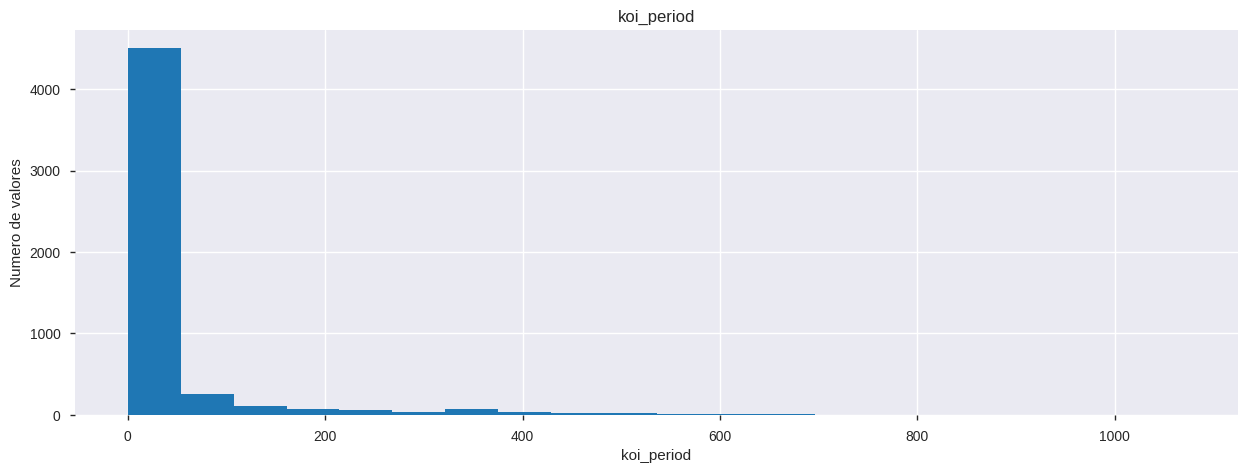

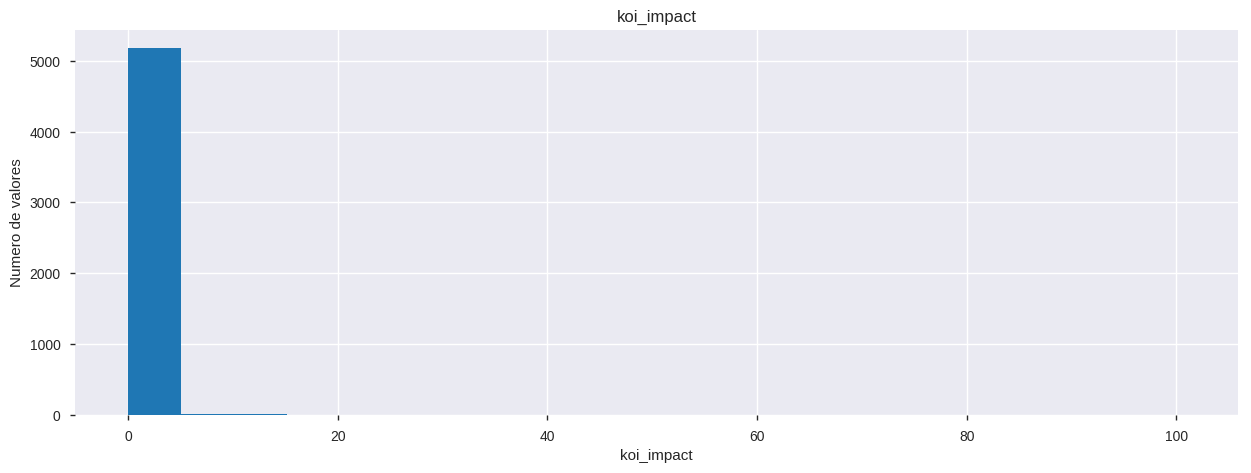

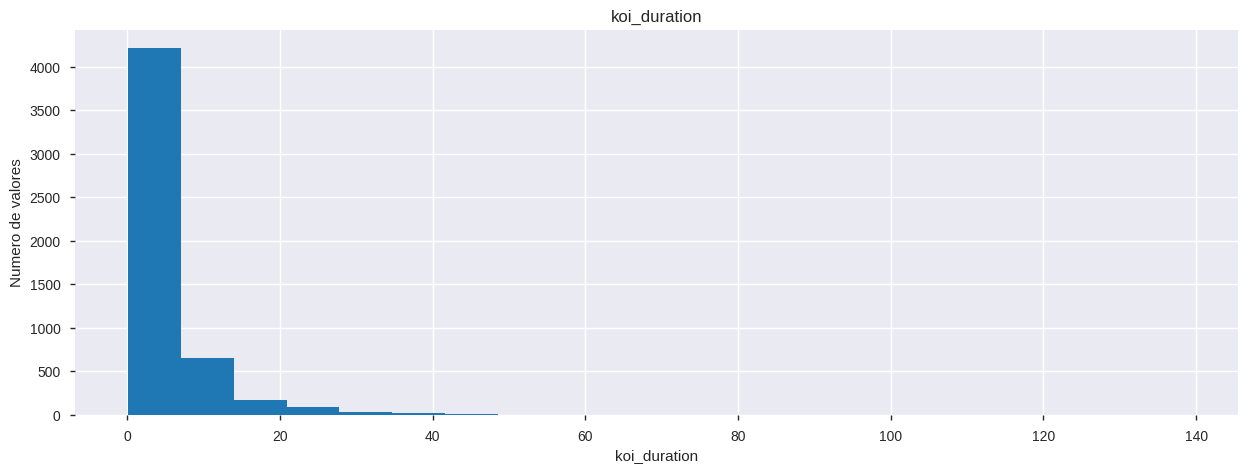

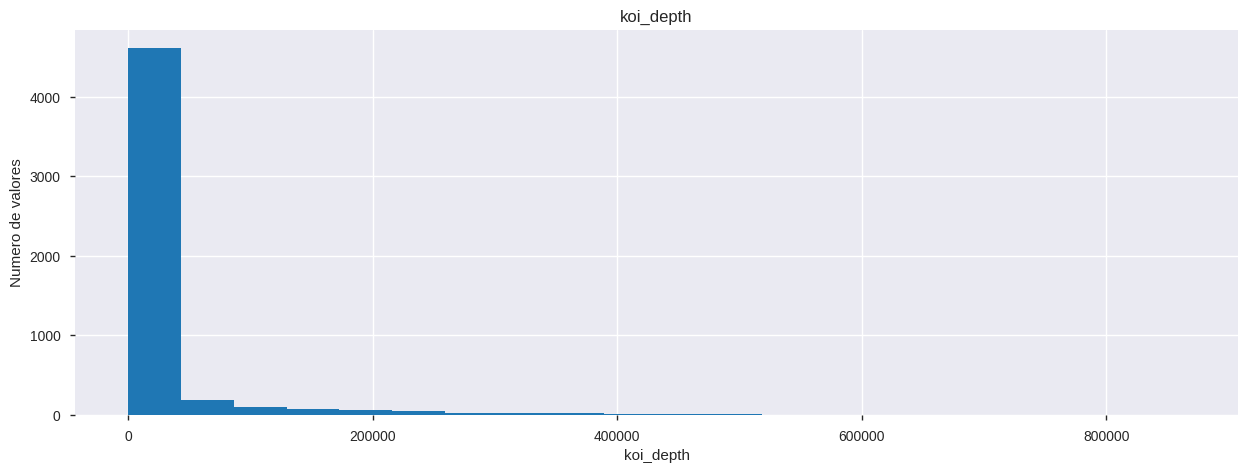

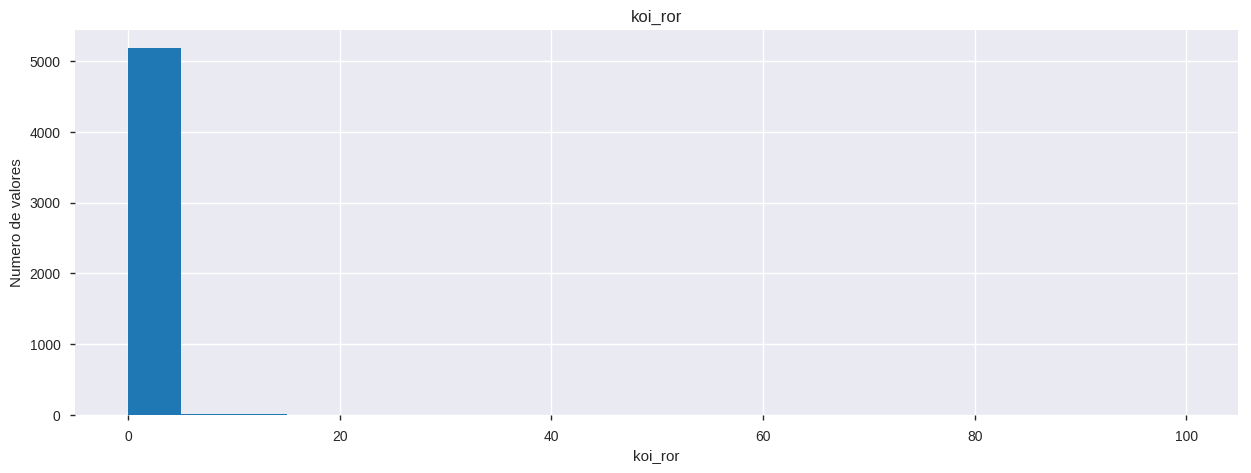

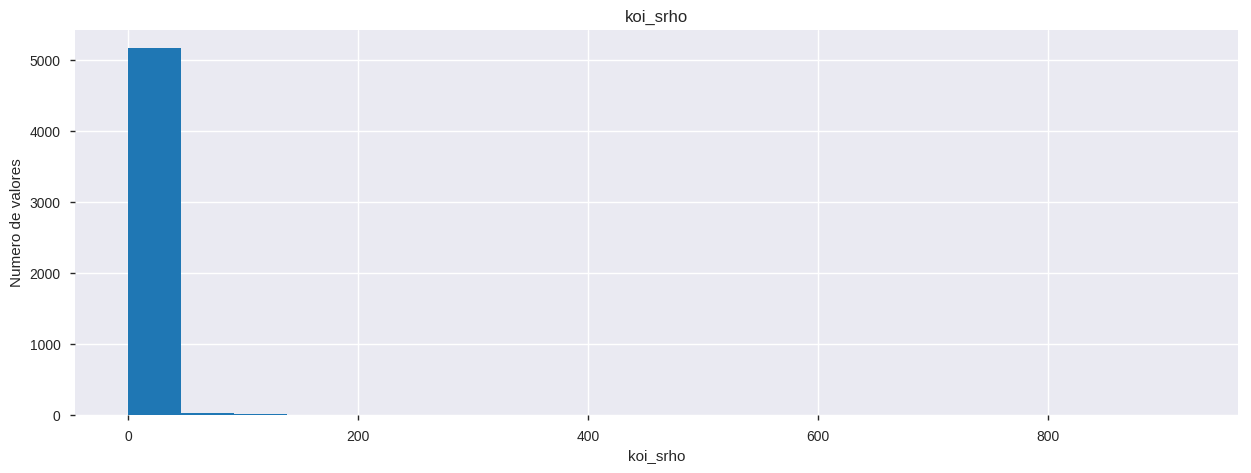

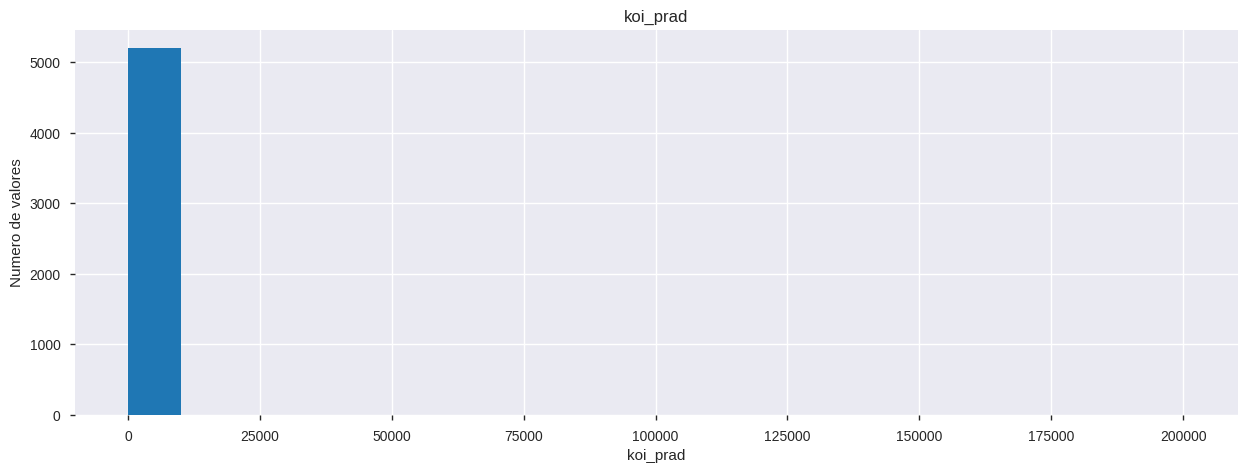

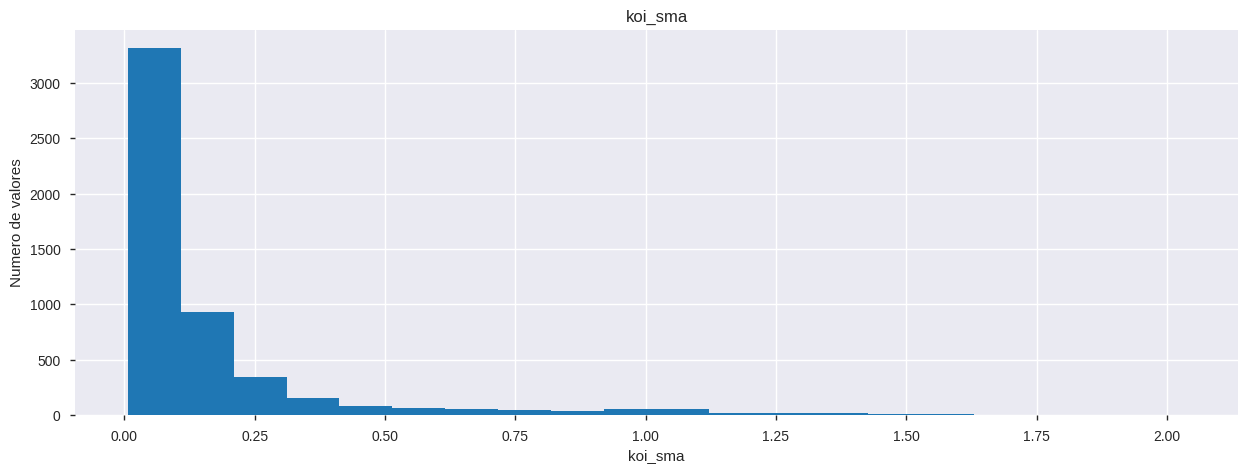

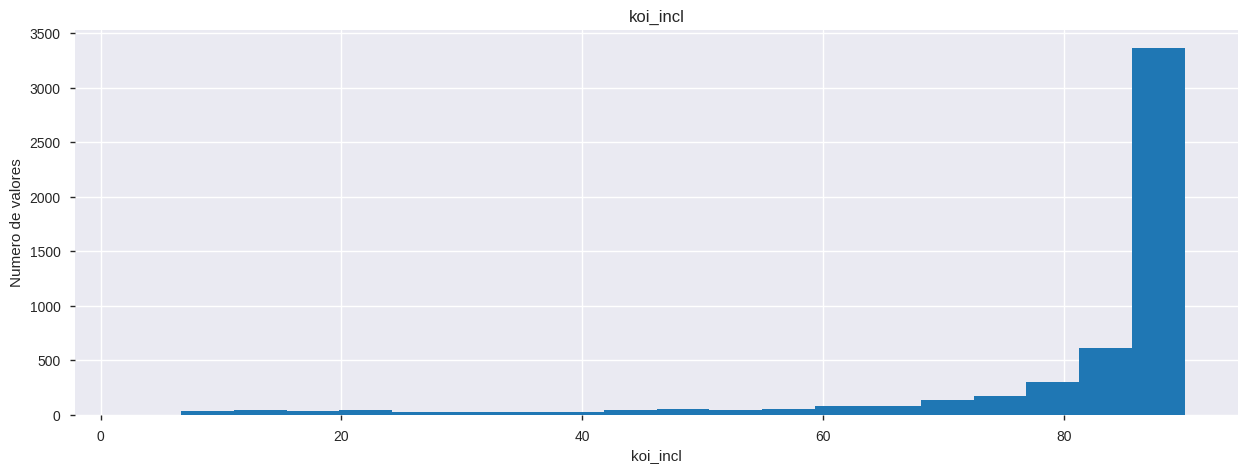

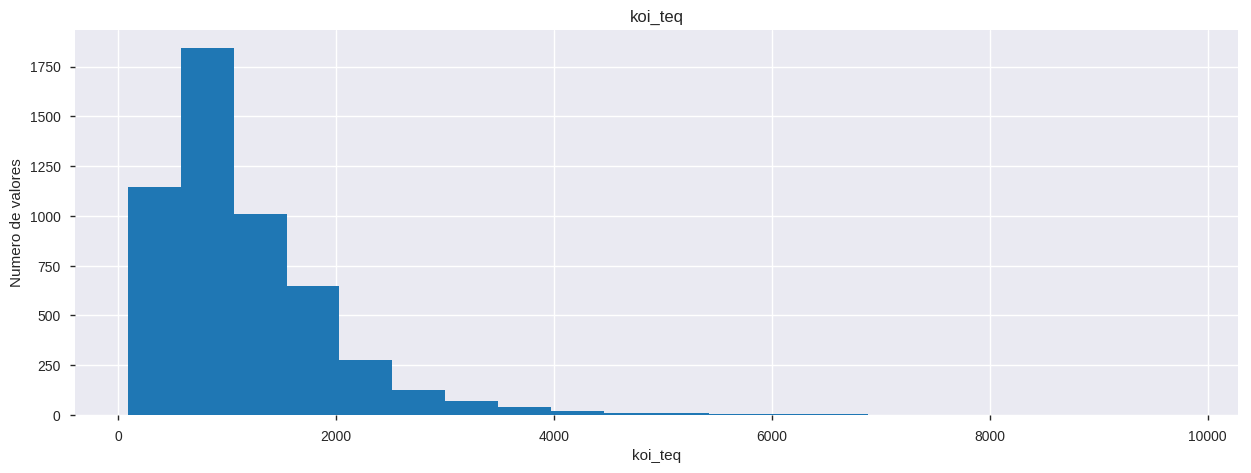

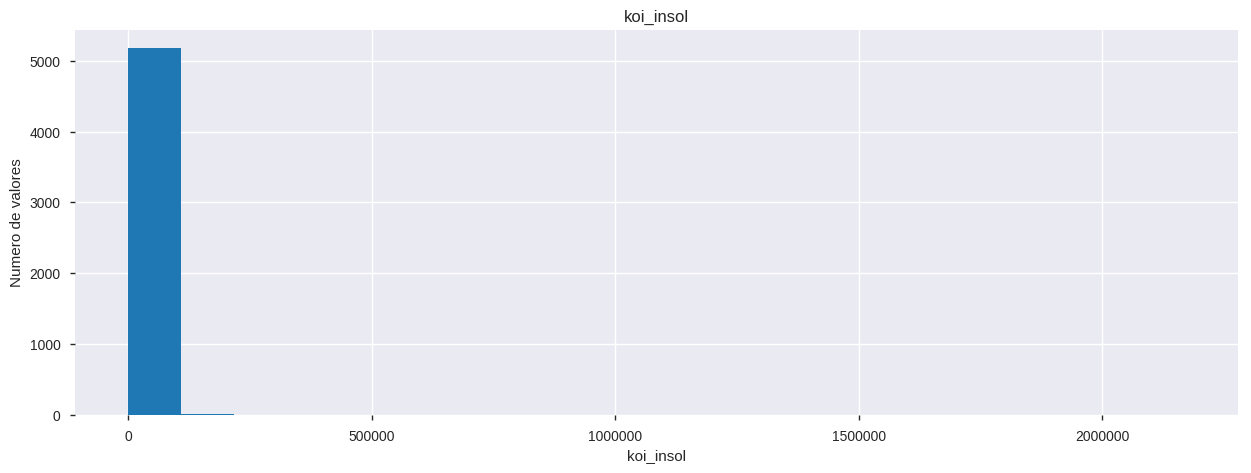

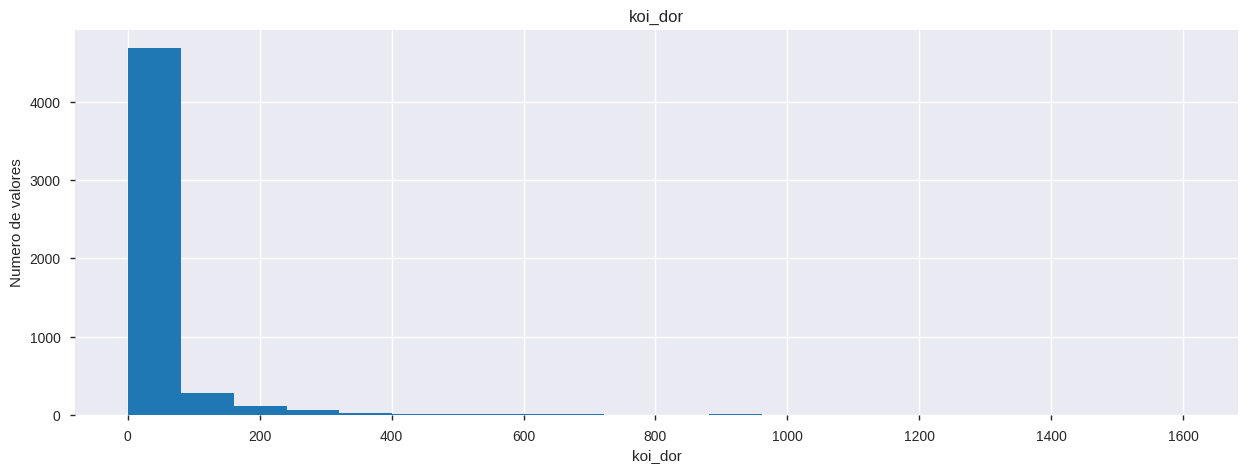

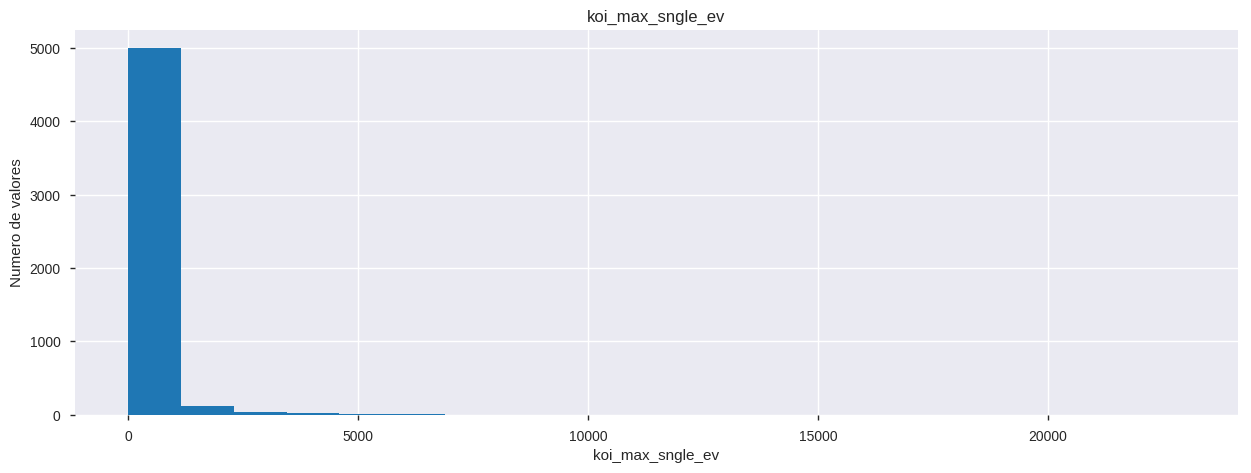

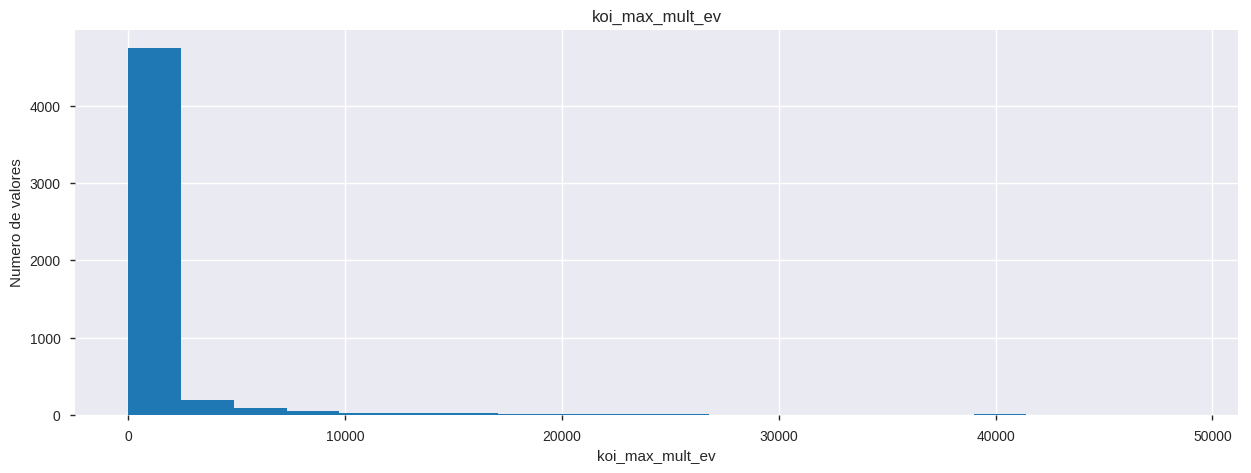

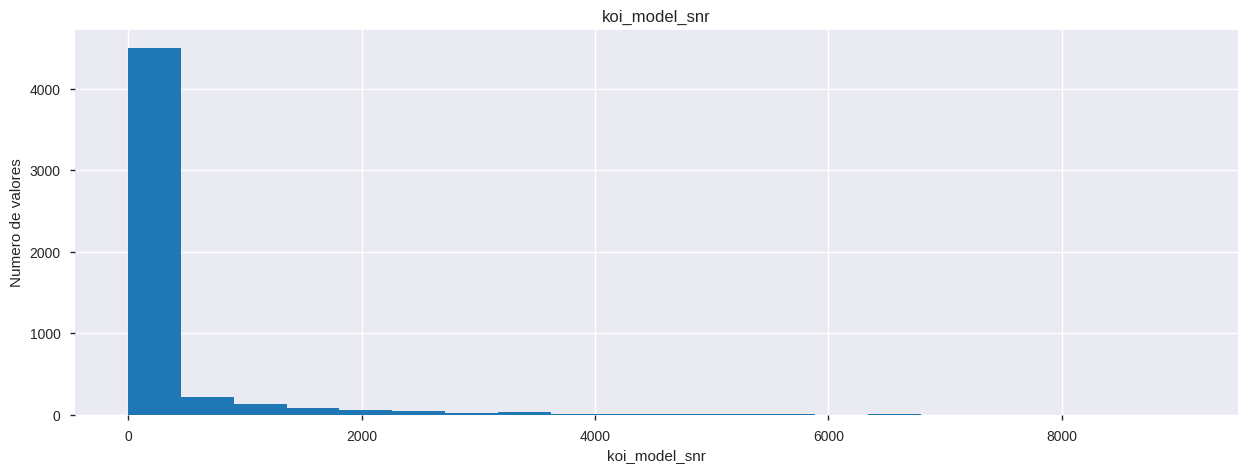

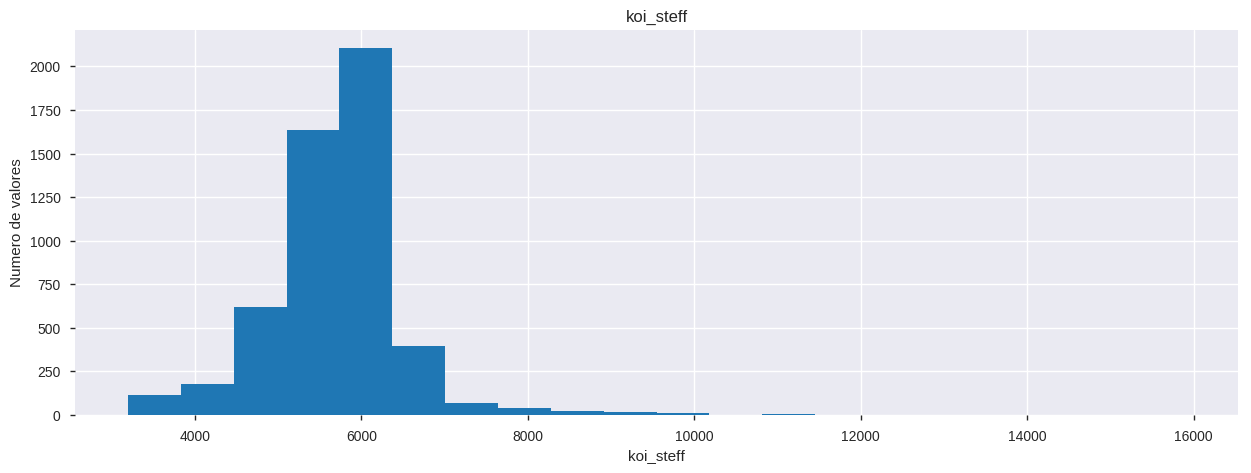

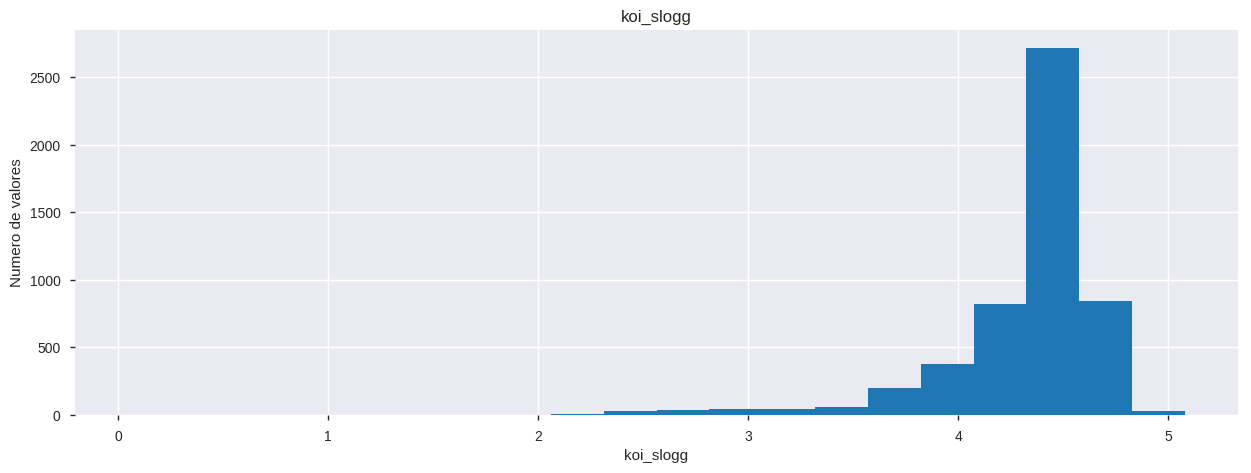

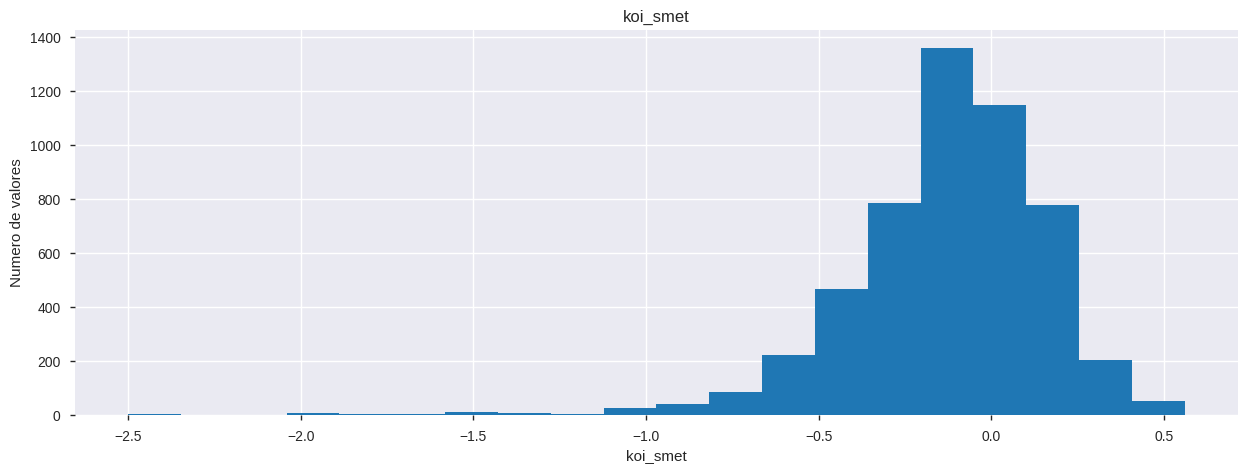

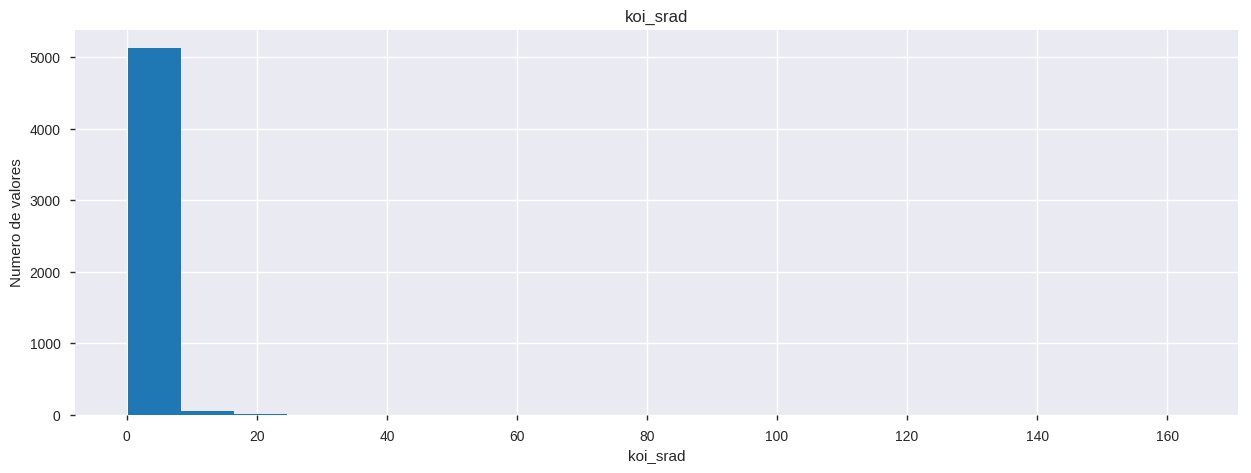

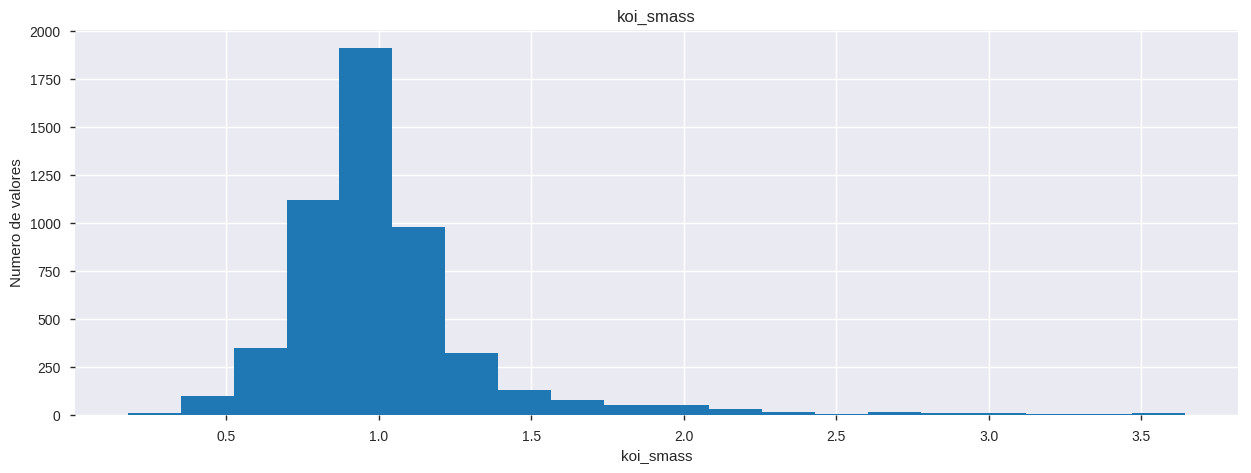

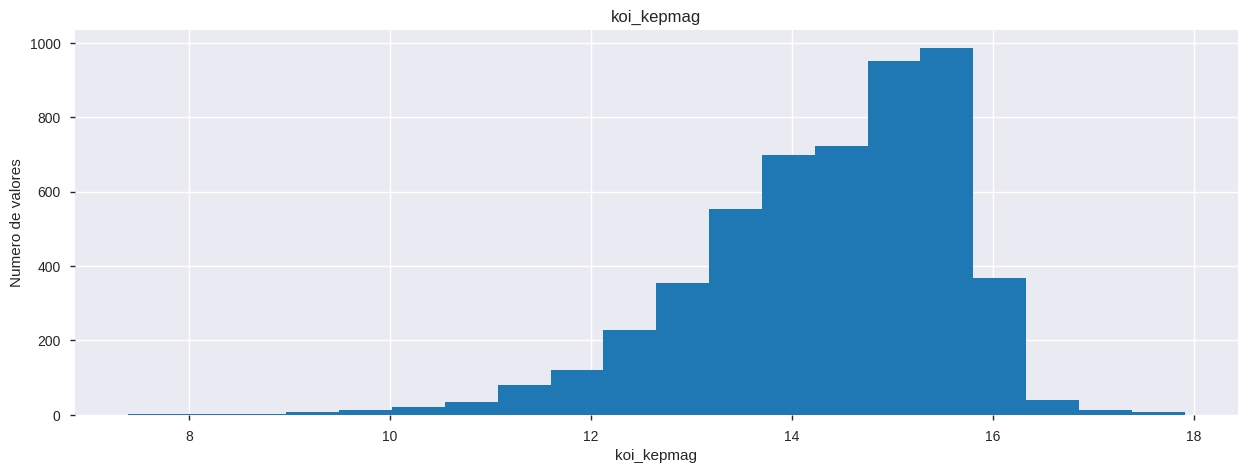

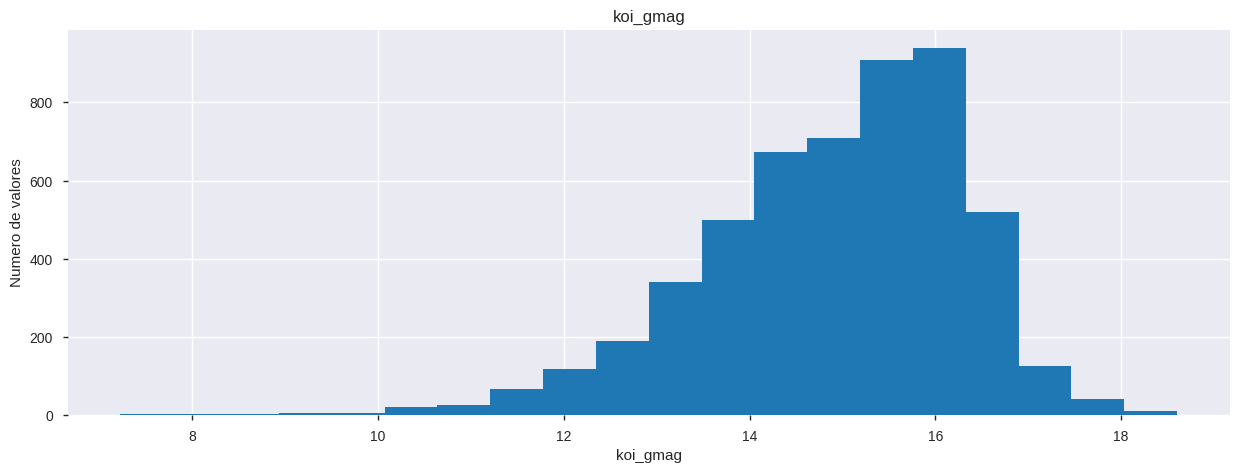

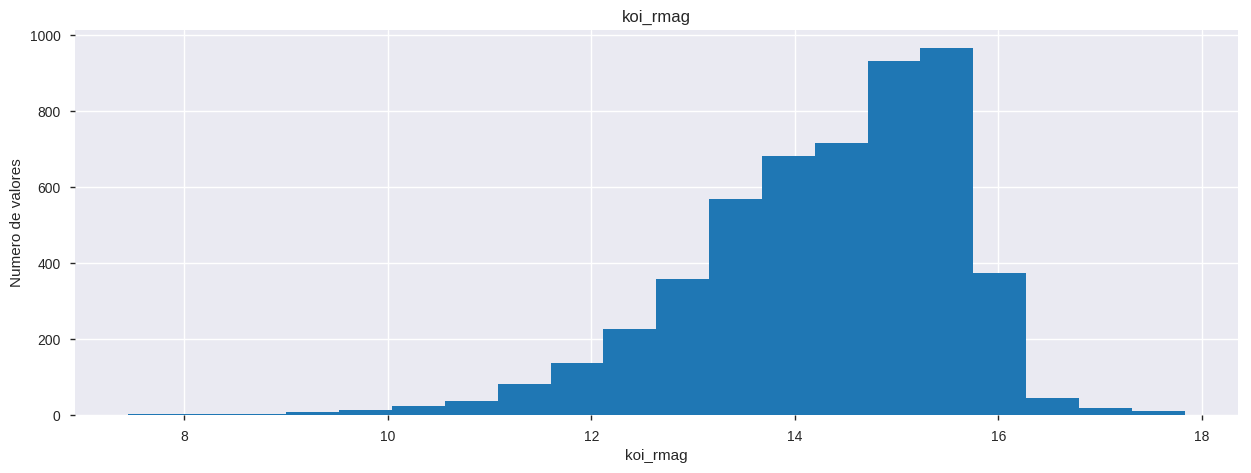

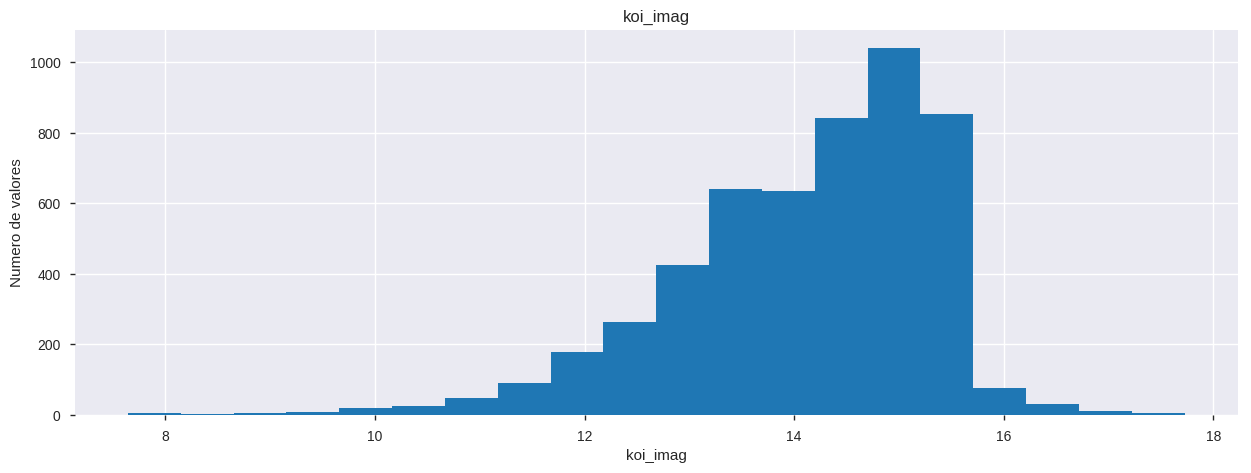

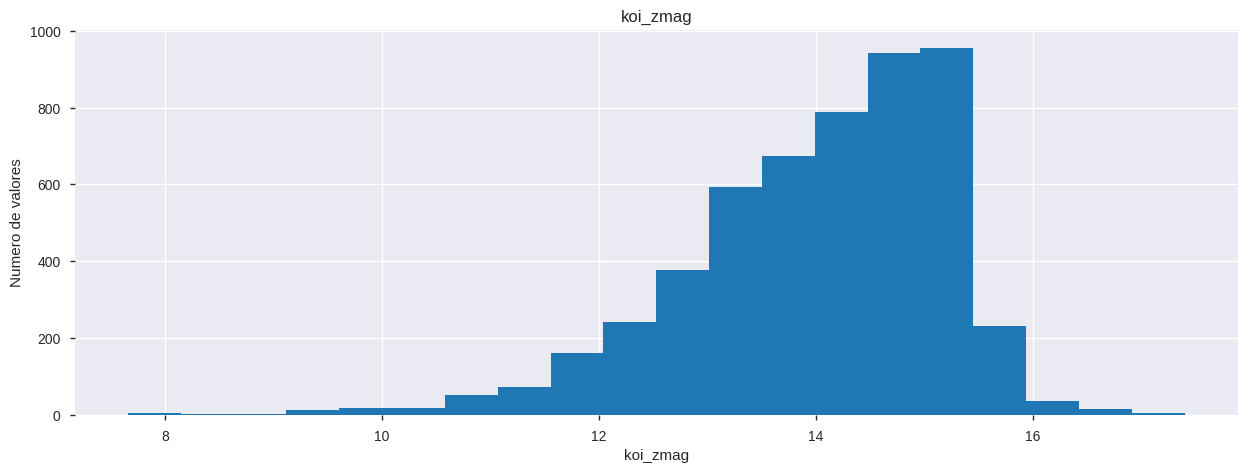

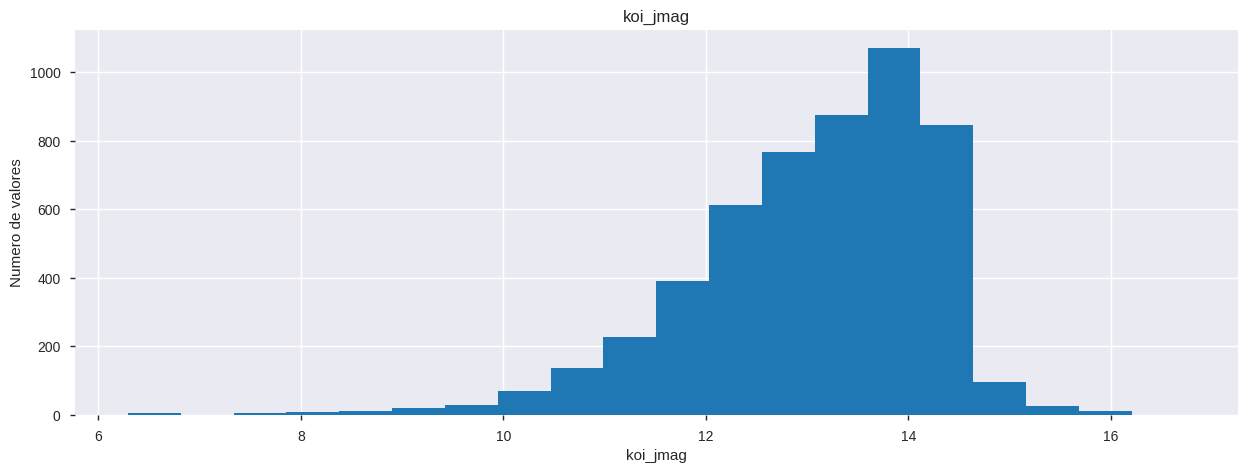

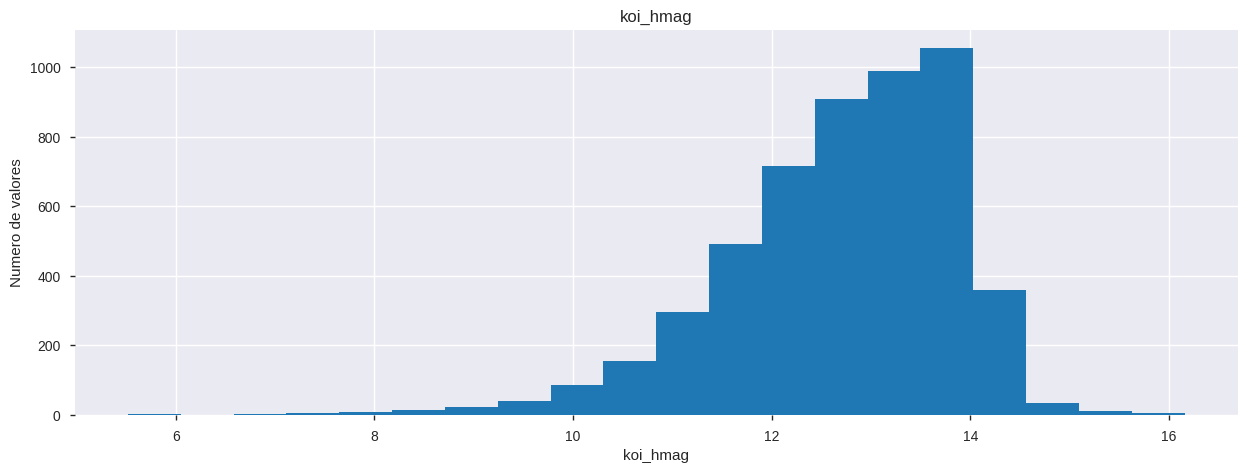

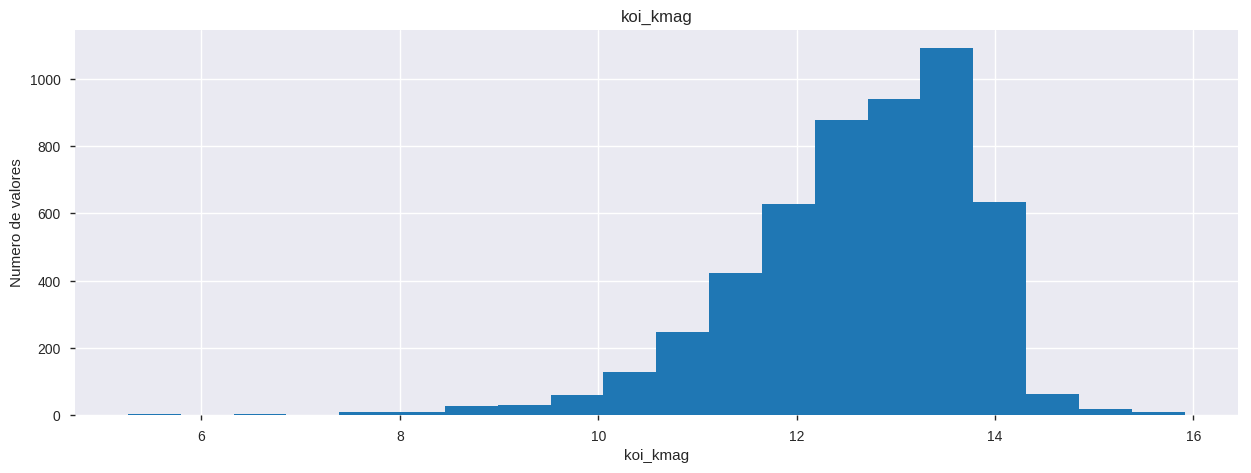

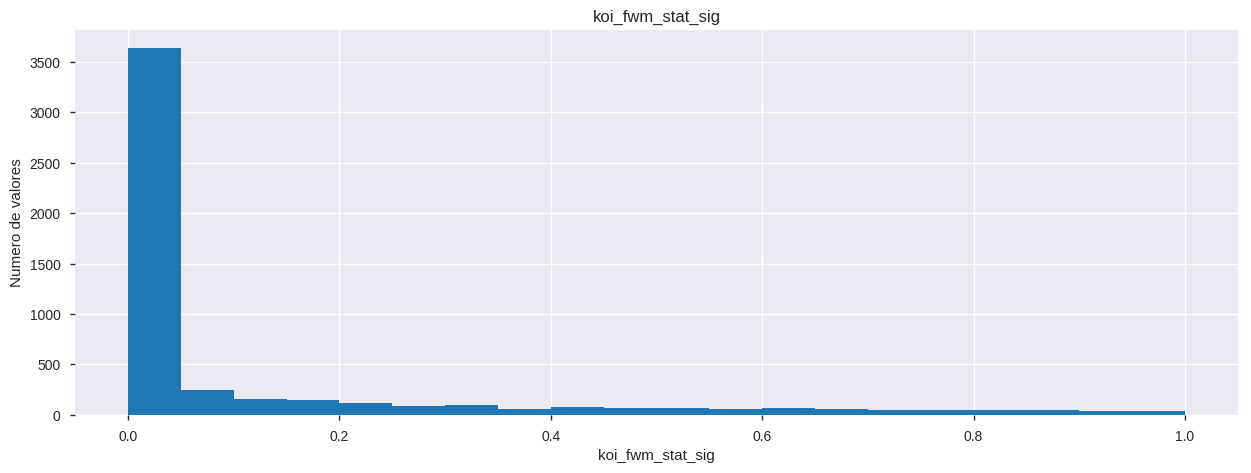

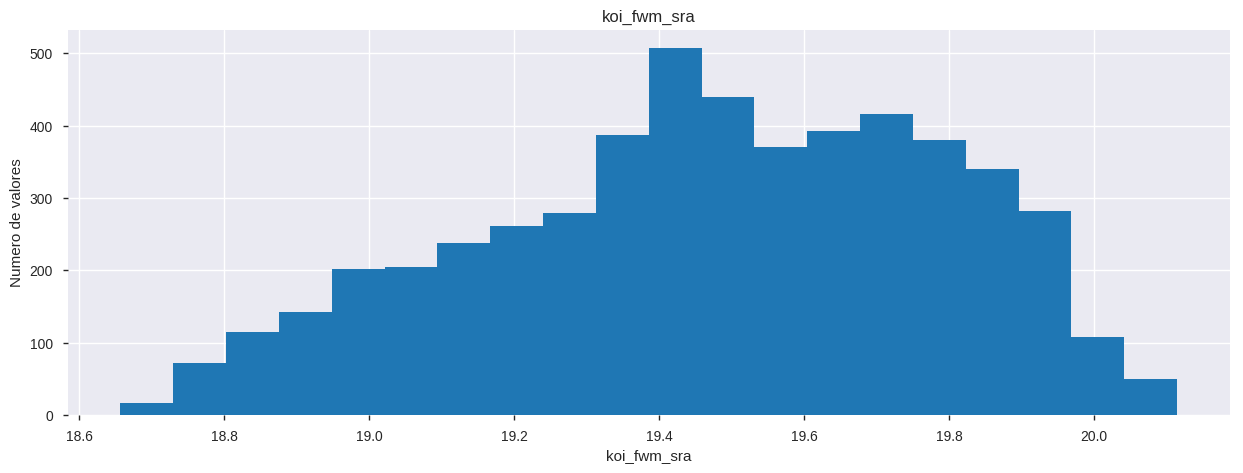

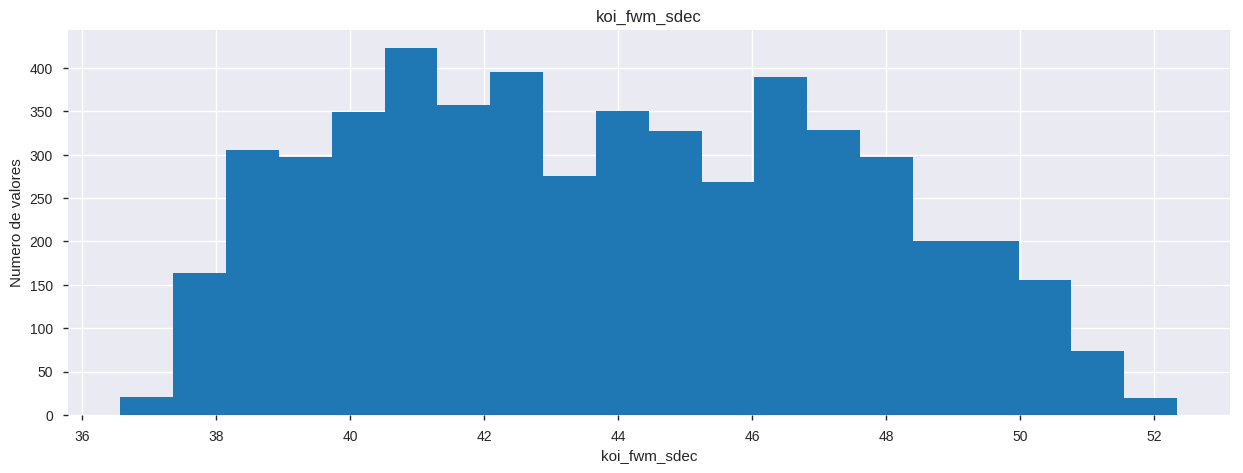

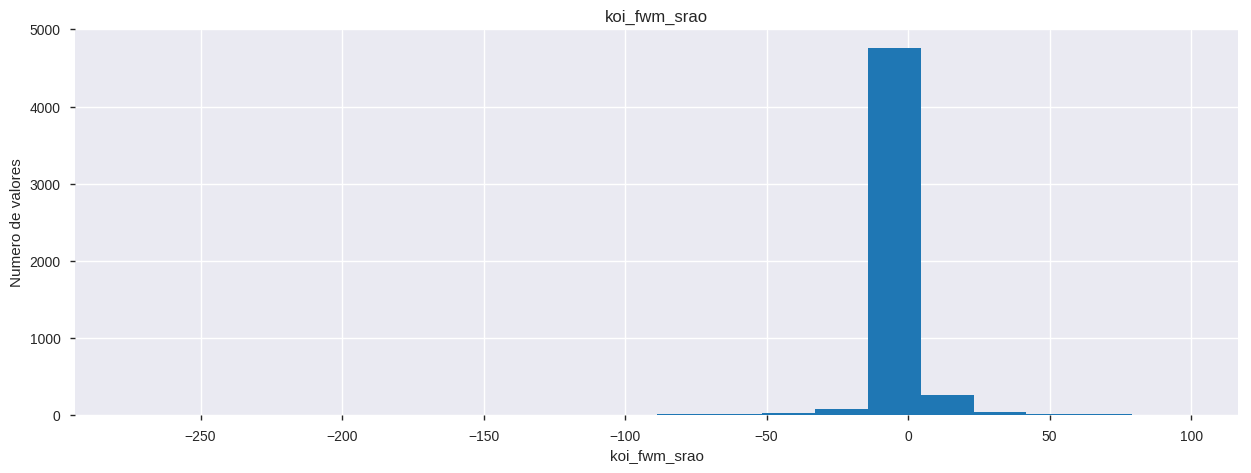

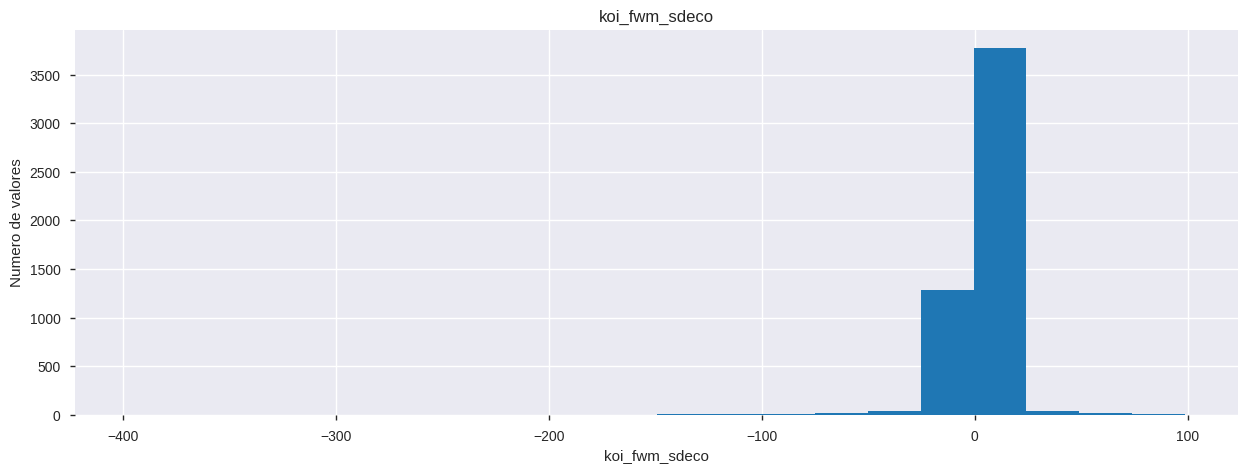

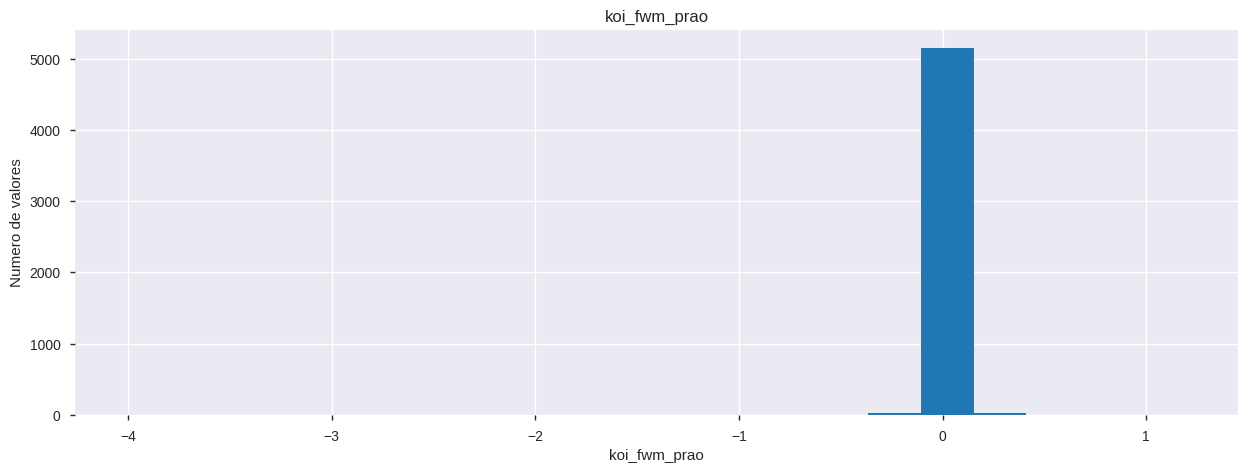

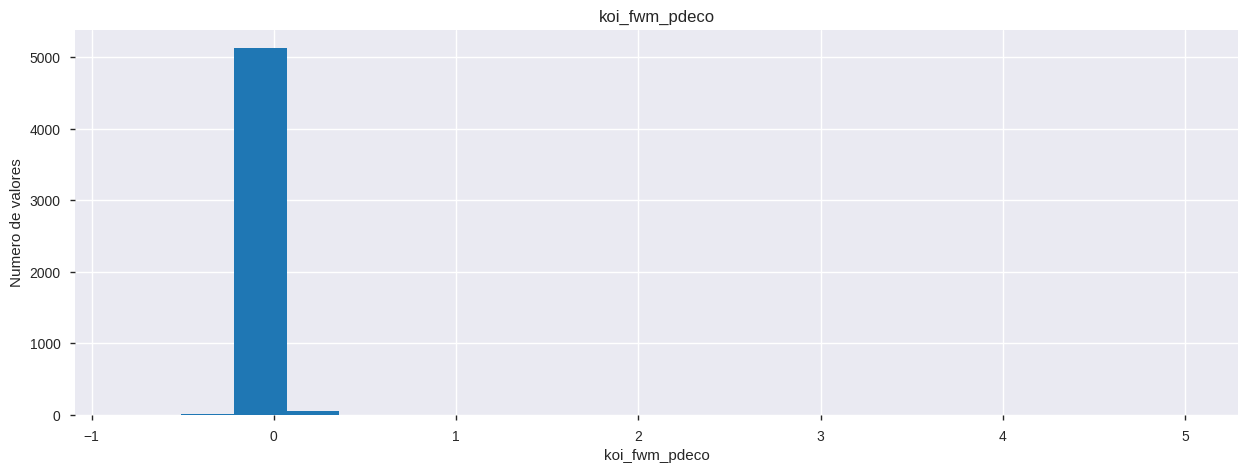

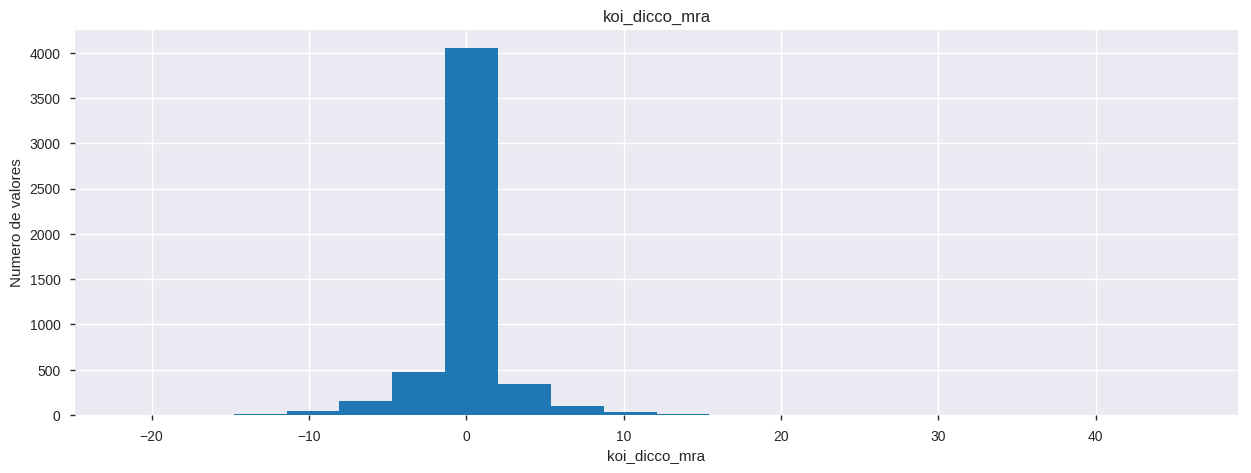

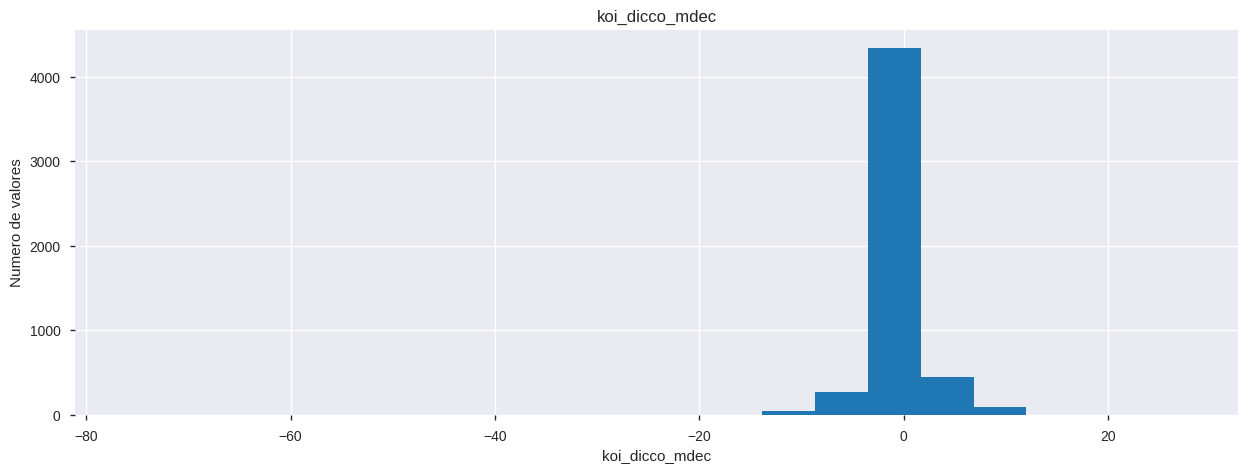

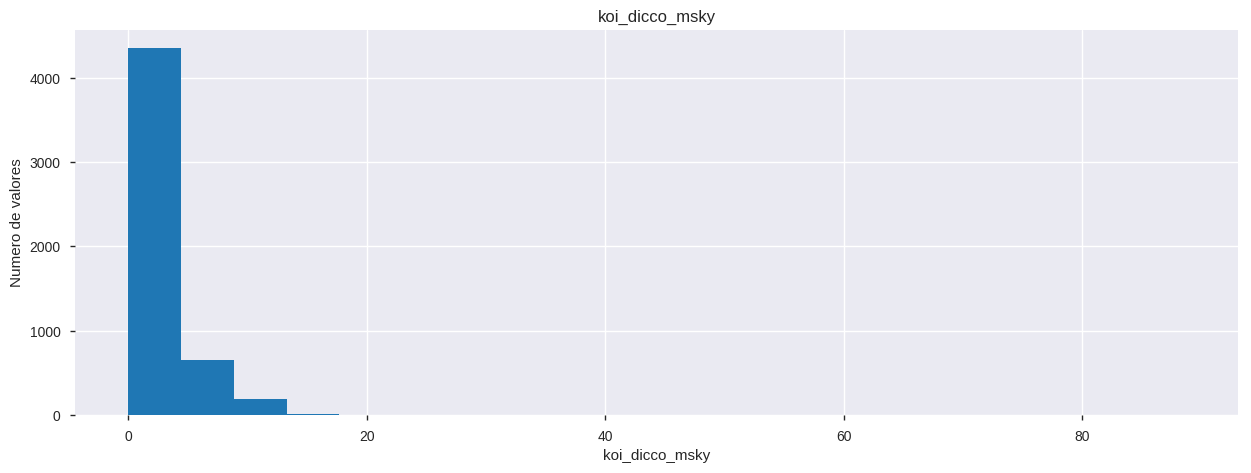

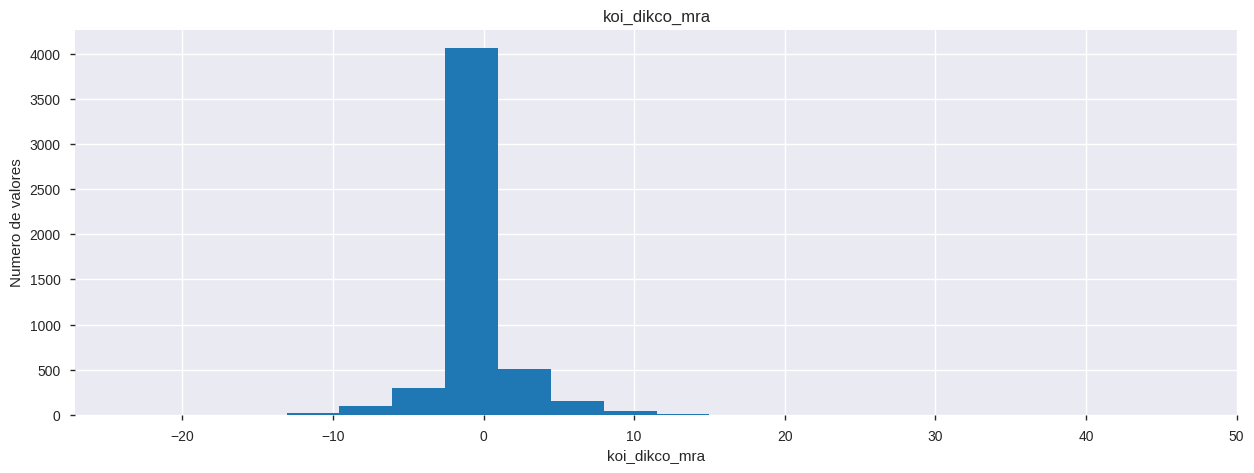

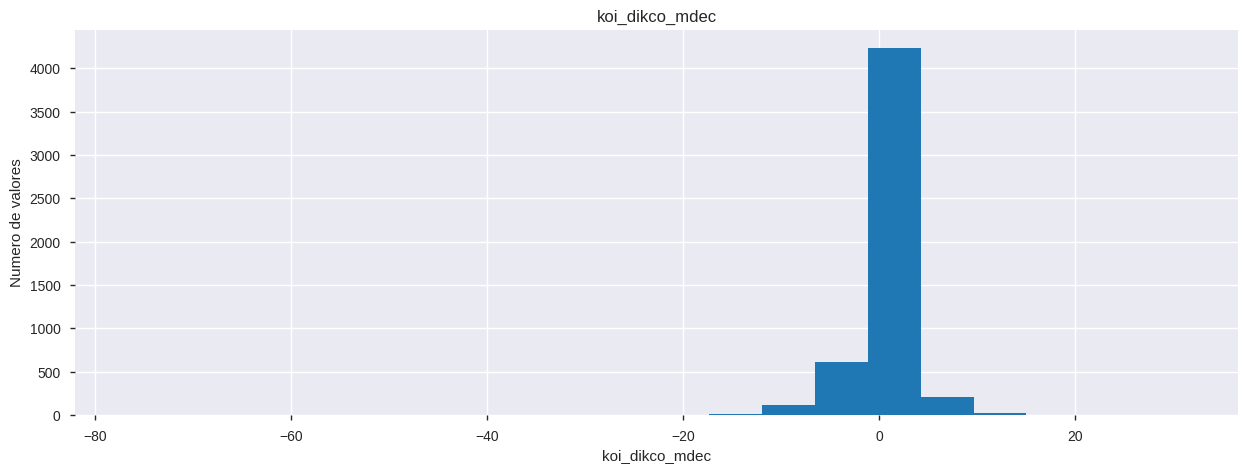

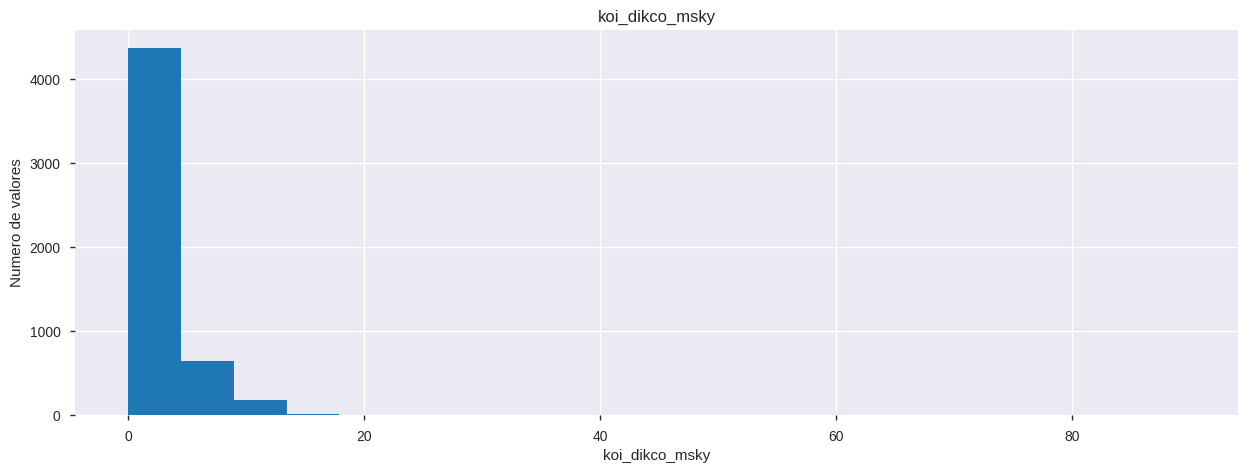

In [18]:
for c in df:
    plt.figure(figsize=(15, 5))
    plt.hist(df[c], bins=20)
    plt.title(c)
    plt.xlabel(c)
    plt.ylabel("Numero de valores")
    plt.show()

### Target

In [14]:
# Exibe a proporção de exemplos em cada classe.

In [15]:
display((y.value_counts()/len(df)*100).round(2).to_frame(TARGET +" (%)").T)

,0,1
koi_disposition (%),59.55,40.45


### Normalização

In [16]:
# Recria a lista com as features
features = list(df.columns)

In [17]:
# Subtrai a media
df[features] = df[features] - df[features].mean()

# Divide pelo desvio padrão
df[features] = df[features] / df[features].std()

print("Resultado:")
df_mean = df[features].mean().round(2).to_frame("Media")
df_std = df[features].std().round(2).to_frame("Std")
with pd.option_context("max_rows", 15):
    display(df_mean.join(df_std))

Resultado:


,Media,Std
koi_period,-0.0,1.0
koi_impact,-0.0,1.0
koi_duration,0.0,1.0
koi_depth,-0.0,1.0
koi_ror,-0.0,1.0
koi_srho,0.0,1.0
koi_prad,0.0,1.0
...,...,...
koi_fwm_pdeco,0.0,1.0
koi_dicco_mra,0.0,1.0


### Função genérica para a validação cruzada

In [69]:
def generic_score(clf):
    score = {
        'acc_train': 0,
        'prec_train': 0,
        'recall_train': 0,
        'acc_test': 0,
        'prec_test': 0,
        'recall_test': 0
    }
    
    kfold = KFold(N_FOLDS, True, 1)
    # enumerate splits
    accuracy_val = []
    precision_val = []
    recall_val = []
    f1_val = []

    accuracy_train = []
    precision_train = []
    recall_train = []
    f1_val = []
    f1_train = []
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    for train_index, test_index in kfold.split(df):
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]
        Y_train, Y_test = y[train_index], y[test_index]
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        x_pred = clf.predict(X_train)

        accuracy_val.append(accuracy_score(Y_test, y_pred))
        accuracy_train.append(accuracy_score(Y_train, x_pred))
    
        precision_val.append(precision_score(Y_test, y_pred))
        precision_train.append(accuracy_score(Y_train, x_pred))
    
        recall_val.append(recall_score(Y_test, y_pred))
        recall_train.append(accuracy_score(Y_train, x_pred))
    
        f1_val.append(f1_score(Y_test, y_pred))
        f1_train.append(accuracy_score(Y_train, x_pred))
        
    score['acc_train'] = np.mean(accuracy_train)
    score['acc_test'] = np.mean(accuracy_val)
    score['prec_train'] = np.mean(precision_train)
    score['prec_test'] = np.mean(precision_val)
    score['recall_train'] = np.mean(f1_train)
    score['recall_test'] = np.mean(f1_val) 
    
    return score

### Função genérica para a validação cruzada e log dos scores

In [18]:
def score(clf):
    kfold = KFold(N_FOLDS, True, 1)
    # enumerate splits
    accuracy_val = []
    precision_val = []
    recall_val = []
    f1_val = []

    accuracy_train = []
    precision_train = []
    recall_train = []
    f1_val = []
    f1_train = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    for train_index, test_index in kfold.split(df):
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]
        Y_train, Y_test = y[train_index], y[test_index]
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        x_pred = clf.predict(X_train)

        accuracy_val.append(accuracy_score(Y_test, y_pred))
        accuracy_train.append(accuracy_score(Y_train, x_pred))
    
        precision_val.append(precision_score(Y_test, y_pred))
        precision_train.append(accuracy_score(Y_train, x_pred))
    
        recall_val.append(recall_score(Y_test, y_pred))
        recall_train.append(accuracy_score(Y_train, x_pred))
    
        f1_val.append(f1_score(Y_test, y_pred))
        f1_train.append(accuracy_score(Y_train, x_pred))
        
        prediction = clf.fit(df.iloc[train_index],y.iloc[train_index]).predict_proba(df.iloc[test_index])
        fpr, tpr, t = roc_curve(y[test_index], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    
    train_acc = np.mean(accuracy_train)
    val_acc = np.mean(accuracy_val)
    train_prec = np.mean(precision_train)
    val_prec = np.mean(precision_val)
    train_f1 = np.mean(f1_train)
    val_f1 = np.mean(f1_val)
 
    print("Acuracia de treino: {:.3}".format(train_acc))
    print("Acuracia de validação: {:.3}".format(val_acc))
    print("Precisão de treino: {:.3}".format(train_prec))
    print("Precisão de validação: {:.3}".format(val_prec))
    print("F1 de treino: {:.3}".format(train_f1))
    print("F1 de validação: {:.3}".format(val_f1))
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.text(0.32,0.7,'More accurate area',fontsize = 12)
    plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
    plt.show()    

### Função genérica para plotar resultados graficamente

In [104]:
from matplotlib.legend_handler import HandlerLine2D
def plot(train_results, test_results, metric, n):
    line1, = plt.plot(range(0,30, 2), train_results, 'b', label='Train' + metric)
    line2, = plt.plot(range(0,30, 2), test_results, 'r', label='Test' + metric)
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel(metric + 'score')
    plt.xlabel('n' + n)
    plt.show()  

## <a name="nb"></a> Baseline (Naive Bayes)

O objetivo deste método é servir como baseline para os próximos experimentos. Assim, apenas um experimento foi feito. Foi feita uma validação cruzada e seleção de features através do *f_classif*, com
**n_features = 40**.

### Classificação e Validação Cruzada com seleção de features

In [52]:
clf = Pipeline([
  ('selector', SelectKBest(f_classif, k=40)),
  ('classifier', GaussianNB())
])

Acuracia de treino: 0.919
Acuracia de validação: 0.919
Precisão de treino: 0.919
Precisão de validação: 0.85
F1 de treino: 0.919
F1 de validação: 0.906


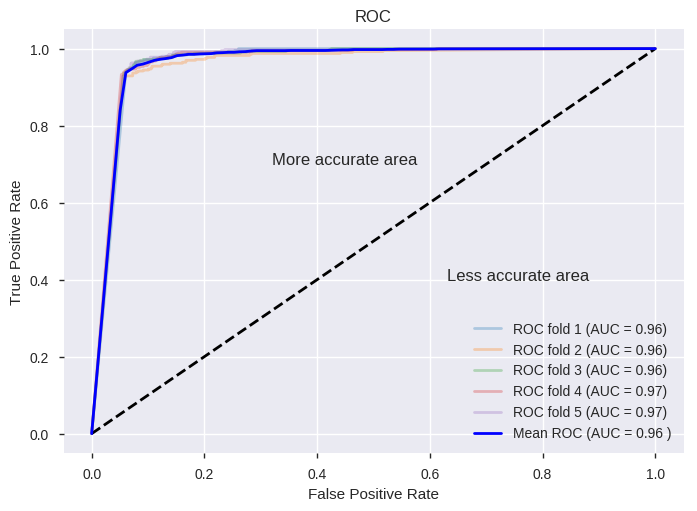

In [53]:
score(clf)

## <a name="dt"></a> Decision Trees

Decision trees (DTs) é um método de aprendizagem supervisionada não paramétrico usado para classificação e regressão. O objetivo é criar um modelo que prevê o valor de uma variável de destino, aprendendo regras de decisão simples inferidas a partir dos recursos de dados.

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import train_test_split

### Max_depth: visualização inicial

O parâmetro ajustado será será *max_depth*. Isso indica o quão profunda a árvore pode ser. Quanto mais profunda a árvore, mais divisões ela tem e captura mais informações sobre os dados. Primeiramente (para visualização - antes dos experimentos em si), nós ajustamos uma árvore de decisão com profundidades que variam de 1 a 42 e plotaremos o *auc-score* para treino e teste.

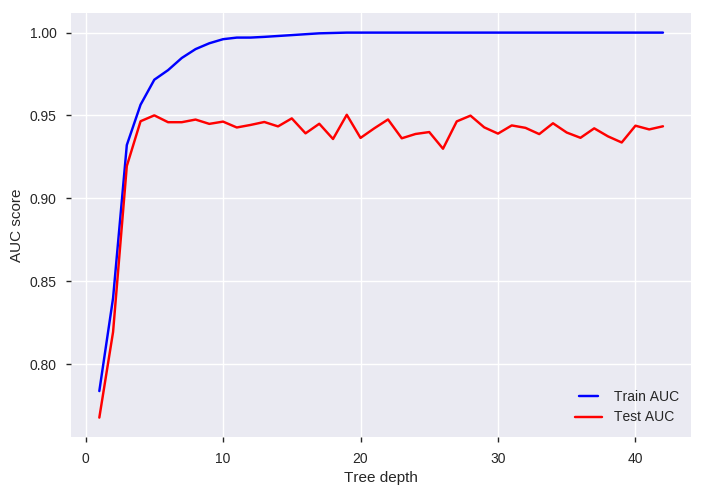

In [27]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.25)

max_depths = np.linspace(1, 42, 42, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

Vemos que nosso modelo *overfita* com grandes valores de altura. A árvore prevê perfeitamente todos os dados do treino, no entanto, não consegue generalizar os resultados para novos dados.

### Experimento 0 Decision Trees: altura da árvore *default*: ilimitada


*max_depth* = None 

*Objetivo do experimento:* servir como *baseline* para os outros experimentos com DT. Servir como comparação base, verificar hipótese de que erro empírico será o menor possível aqui, devido à maior complexidade do modelo com altura ilimitada.

In [55]:
tree = DecisionTreeClassifier(random_state=0)

Acuracia de treino: 1.0
Acuracia de validação: 0.945
Precisão de treino: 1.0
Precisão de validação: 0.927
F1 de treino: 1.0
F1 de validação: 0.932


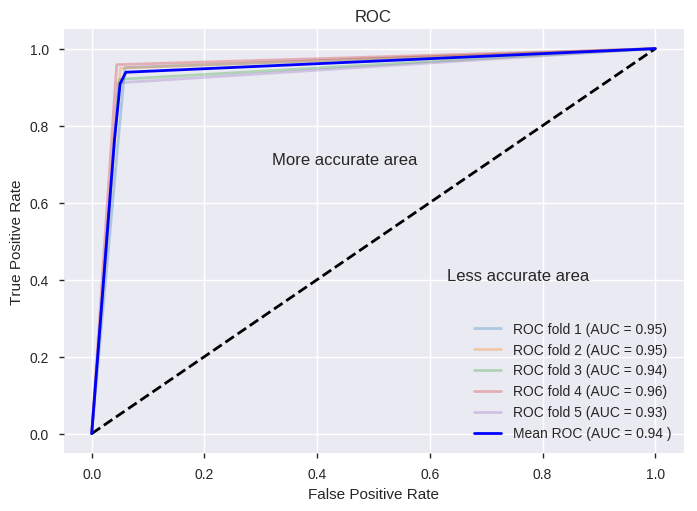

In [56]:
score(tree)

*Interpretação dos resultados:* minha hipótese se confirmou, o erro empírico foi igual a 0. O modelo *overfitou* devido à complexidade do modelo. Nos próximos experimentos, tentarei limitar os valores da altura. Modelo não generalizou bem.

### Experimento 1 Decision Trees: altura da árvore igual a 5

*Objetivo do experimento*: verificar se, com uma altura próxima de 0, o modelo *overfita* menos e fica com métricas melhores. Uma altura próxima de 0 demonstra um modelo menos complexo, porém pode causar pouca flexibilidade para capturar os padrões dos dados. Hipótese: overfita menos, porém com erro esperado é maior do que o do *experimento 0*.

In [58]:
max_depth = 5
tree = DecisionTreeClassifier(random_state=0, max_depth=max_depth)

Acuracia de treino: 0.965
Acuracia de validação: 0.951
Precisão de treino: 0.965
Precisão de validação: 0.926
F1 de treino: 0.965
F1 de validação: 0.94


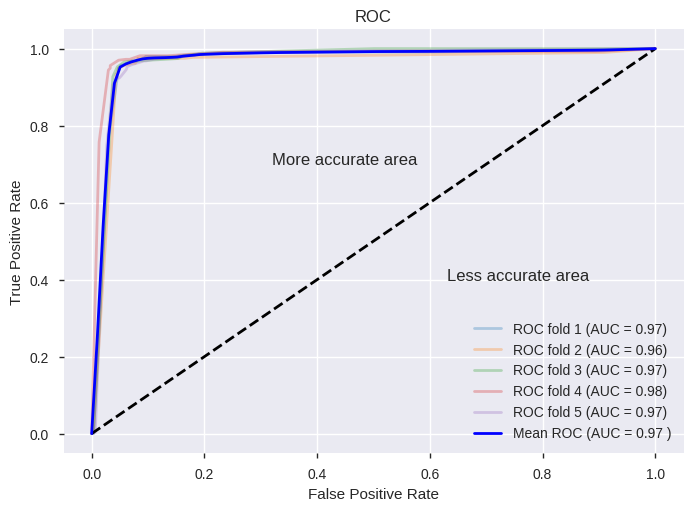

In [59]:
score(tree)

*Interpretação dos resultados:* o modelo *overfitou* menos, e o erro esperado foi *menor* que o experimento anteior, contrariando minha hipótese. Isso ocorreu devido ao fato de que os padrões dos dados não exigirem uma complexidade grande do modelo. No próximo experimento, aumentarei um pouco a altura da árvore.

### Experimento 2 Decision Trees: altura da árvore igual a 10

*Objetivo do experimento*: verificar se, com uma altura um pouco maior(10), o modelo *overfita* mais e fica com métricas melhores. Hipótese: overfita mais, porém com erro esperado é menor do que o do *experimento 1*.

In [60]:
max_depth = 10
tree = DecisionTreeClassifier(random_state=0, max_depth=max_depth)

Acuracia de treino: 0.991
Acuracia de validação: 0.95
Precisão de treino: 0.991
Precisão de validação: 0.924
F1 de treino: 0.991
F1 de validação: 0.939


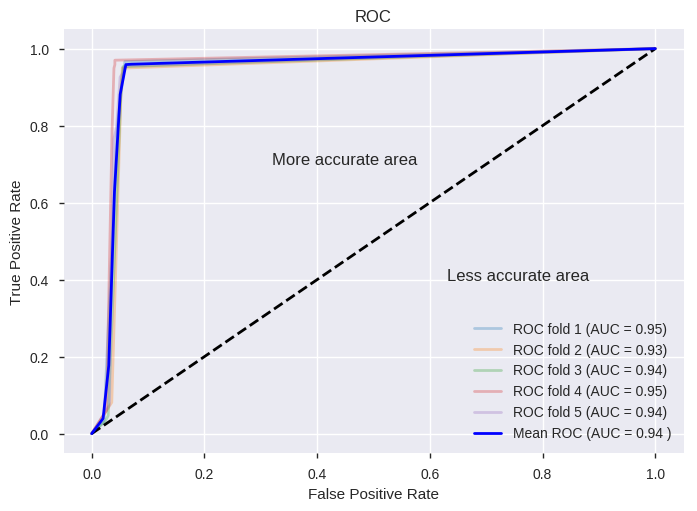

In [61]:
score(tree)

Interpretação dos resultados: o modelo overfitou mais, e o erro esperado foi maior que o experimento anteior, contrariando minha hipótese. Isso ocorreu devido ao fato de que os padrões dos dados não exigirem uma complexidade grande do modelo, sendo alturas menores melhores para esse caso. No próximo experimento, diminuir um pouco a altura da árvore com relação ao experimento 0.

### Experimento 3 Decision Trees: altura da árvore igual a 3

*Objetivo:* verificar o impacto de uma altura bem próxima de 0(3). Hipótese: prevejo que o modelo irá *underfittar* devido à pouca complexidade do modelo.

In [62]:
max_depth = 3
tree = DecisionTreeClassifier(random_state=0, max_depth=max_depth)

Acuracia de treino: 0.931
Acuracia de validação: 0.928
Precisão de treino: 0.931
Precisão de validação: 0.882
F1 de treino: 0.931
F1 de validação: 0.914


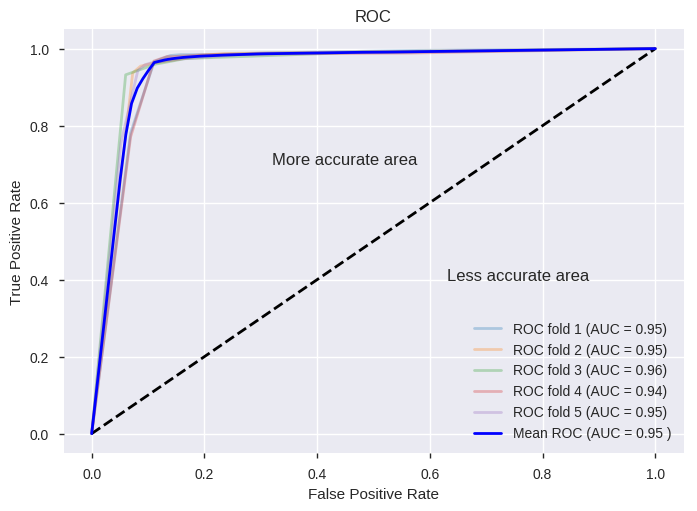

In [63]:
score(tree)

*Interpretação dos resultados*: minha hipótese se confirmou - o modelo *underfittou* devido à baixa complexidade do modelo.

### Interpretação dos resultados gerais da Decision Tree:

Para erros de treino, é fácil ver o que vai acontecer. Se você aumentar *max_depth*, o erro de treino não aumentará. Justificativa: quanto mais alta a árvore, mais complexo seu modelo se tornará.

Para erros de teste, fica menos óbvio. Se você definir *max_depth* muito alto, a árvore de decisão pode simplesmente *overfitar* os dados de treino sem capturar padrões úteis como gostaríamos; Isso fará com que o erro de teste aumente. Mas se você definir muito baixo, isso também não é bom; então você pode estar dando à árvore de decisão muito pouca flexibilidade para capturar os padrões e interações nos dados de treinamento. Isso também fará com que o erro de teste aumente.

## <a name="svm"></a> Support Vector Machines

O SVM classifica os pontos de dados usando uma linha reta. Alguns conjuntos de dados são impossíveis de separar por linha reta. Para
lidar com esse problema, a função do kernel é utilizada. A idéia central da função kernel é projetar pontos em uma dimensão mais alta
do espaço na esperança de que a separabilidade dos dados iria melhorar. Existem vários kernels, como o linear, sigmoide, polinomial e RBF.

### Linear

Hipótese: o kernel linear funciona bem se o seu conjunto de dados for linearmente separável; no entanto, se o seu conjunto de dados não for linearmente separável, um kernel linear não funcionará bem. Se o número de *features* for grande e maior que o número de exemplos de treino (poucos dados), o linear será a melhor escolha, tendo em conta que não há dados suficientes para uma função muito complexa - a linear provavelmente é suficiente, sendo comparável à regressão logística (*perceptron*).

*Objetivo:* como no exemplo há mais dados de treino que features, o linear não será a melhor escolha, porém rodará mais rápido que os demais.

In [66]:
clf = SVC(kernel='linear', probability=True)

Acuracia de treino: 0.955
Acuracia de validação: 0.952
Precisão de treino: 0.955
Precisão de validação: 0.924
F1 de treino: 0.955
F1 de validação: 0.942


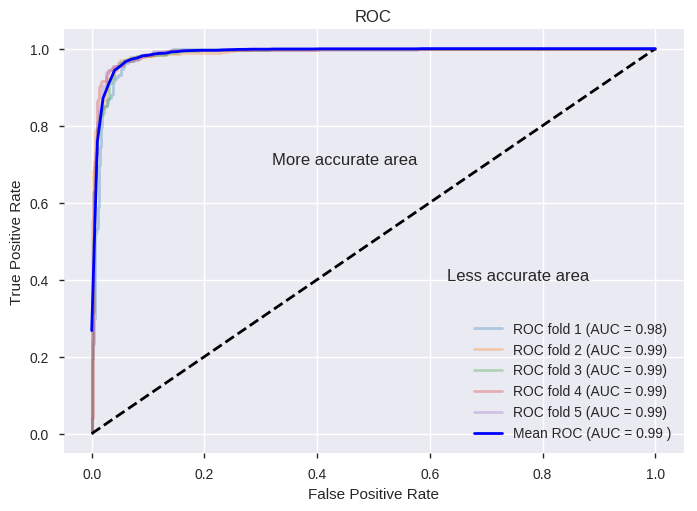

In [67]:
score(clf)

*Interpretação dos resultados:* os resultados foram melhores que o esperado, contrariando minha hipótese. Isso ocorre

### Sigmoide



O kernel sigmóide era bastante popular para SVM's devido à sua origem
de redes neurais

*Objetivo:*

In [73]:
clf = SVC(kernel='sigmoid', probability=True)

Acuracia de treino: 0.834
Acuracia de validação: 0.834
Precisão de treino: 0.834
Precisão de validação: 0.793
F1 de treino: 0.834
F1 de validação: 0.796


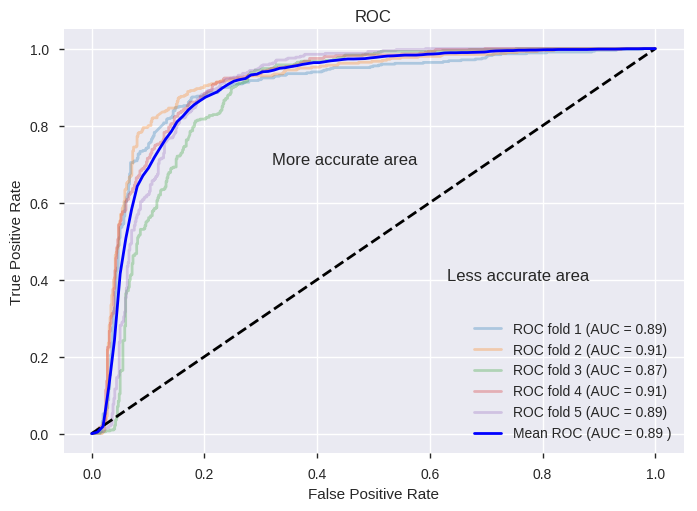

In [74]:
score(clf)

*Interpretação dos resultados:*

### Polinomial

*Objetivo:*

In [78]:
clf = SVC(kernel='poly', probability=True)

Acuracia de treino: 0.891
Acuracia de validação: 0.882
Precisão de treino: 0.891
Precisão de validação: 0.783
F1 de treino: 0.891
F1 de validação: 0.87


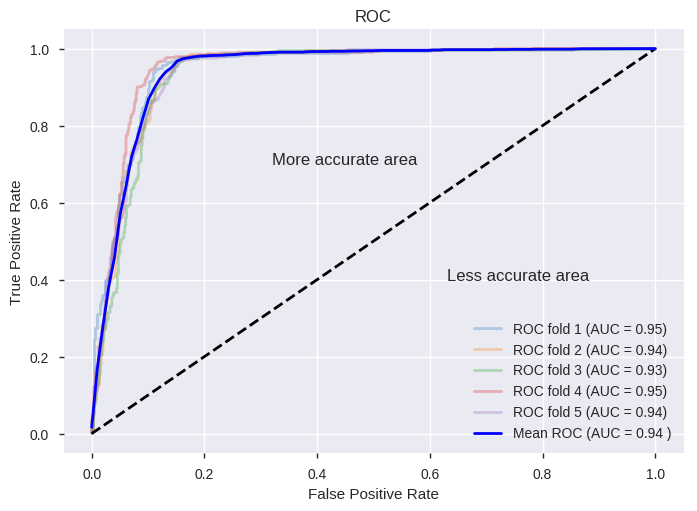

In [79]:
score(clf)

*Interpretação dos resultados:*

### Gaussian (RBF)

*Objetivo:*

In [84]:
clf = SVC(kernel='rbf', probability=True)

Acuracia de treino: 0.942
Acuracia de validação: 0.937
Precisão de treino: 0.942
Precisão de validação: 0.893
F1 de treino: 0.942
F1 de validação: 0.924


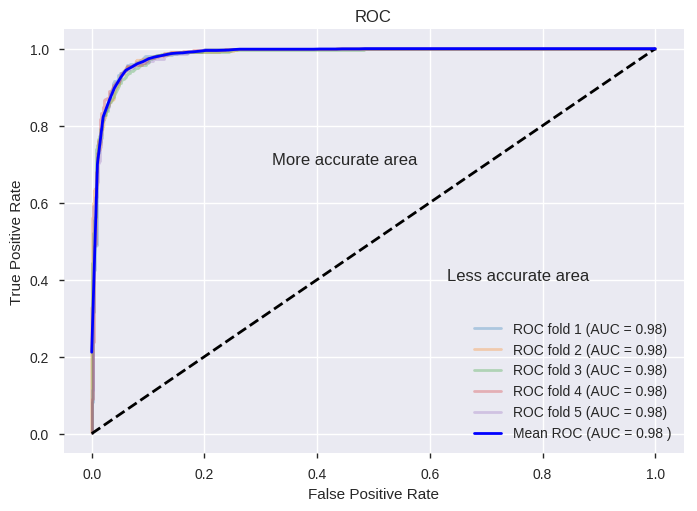

In [85]:
score(clf)

*Interpretação dos resultados:*

### Interpretação geral dos resultados do SVM:

t the linear kernel is
essentially a special case of the RBF kernel, among existing kernels, RBF should be the
first choice for general users.

## <a name="knn"></a> k-NN

O algoritmo de kNN é um método de aprendizagem não-paramétrico usado para classificação e regressão. A saída é com base no voto da maioria (para classificação) ou média (ou mediana, para regressão) dos k vizinhos mais próximos no espaço de *features*.

### Visualização inicial dos resultados

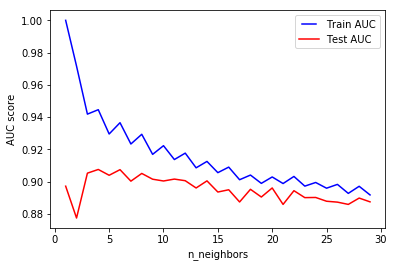

In [28]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.25)

neighbors = list(range(1,30))
train_results = []
test_results = []
for n in neighbors:
   model = KNeighborsClassifier(n_neighbors=n)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(neighbors, train_results, 'b', label='Train AUC')
line2, = plt.plot(neighbors, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')
plt.show()

Usando n_neighbors=1 significa que cada sample está usando ela mesma como referência, e o modelo *overfita*. Para esses dados, o modelo melhora até certo ponto, com n_neighbors próximo de 5 sendo os melhores resultados.



### Experimento 0: número de vizinhos default - 5

*Objetivo:*  primeiramente vamos treinar o kNN com os parâmetros *default* para ter uma *baseline* da performance. 

Acuracia de treino: 0.921
Acuracia de validação: 0.894
Precisão de treino: 0.921
Precisão de validação: 0.809
F1 de treino: 0.921
F1 de validação: 0.88


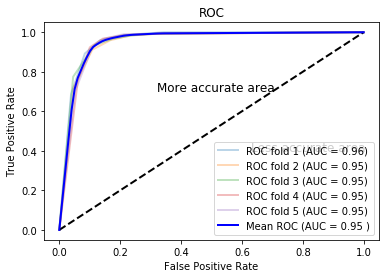

In [21]:
neigh = KNeighborsClassifier()
score(neigh)

*Interpretação dos resultados:* o modelo overfitou. Poucos vizinhos aumentam a complexidade do modelo.

### Experimento 1: número de vizinhos igual a 1.

*Objetivo:* verificar se o viés será 0 e a variância alta, ou seja **modelo mais complexo**.


Acuracia de treino: 1.0
Acuracia de validação: 0.891
Precisão de treino: 1.0
Precisão de validação: 0.817
F1 de treino: 1.0
F1 de validação: 0.874


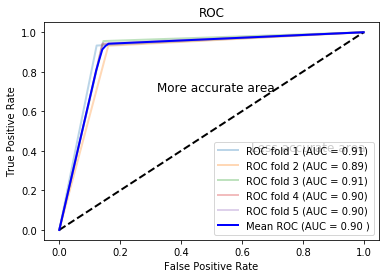

In [31]:
neigh = KNeighborsClassifier(n_neighbors=1)
score(neigh)

*Interpretação dos resultados:* o modelo *overfitou*, como previsto e explicado acima.

### Experimeto 2: número de vizinhos igual a 100.

*Objetivo:* verificar se o modelo underfita com um grande número de vizinhos.

Acuracia de treino: 0.647
Acuracia de validação: 0.648
Precisão de treino: 0.647
Precisão de validação: 0.535
F1 de treino: 0.647
F1 de validação: 0.696


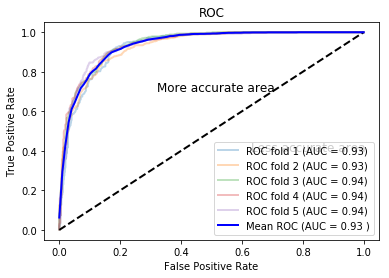

In [41]:
neigh = KNeighborsClassifier(n_neighbors=1000)
score(neigh)

*Interpretação:* modelo underfitou devido à baixa complexidade do modelo.

### Interpretação geral dos resultados do kNN:

Considere um caso extremo, K = 1, o que acontecerá? Os dados de treino serão perfeitamente previstos, certo? O viés será 0 quando K = 1, no entanto, quando se trata de novos dados (em conjunto de teste), tem maior chance de ser um erro, o que causa alta variância. Quando aumentamos K, o erro de treino aumentará (aumento de viés), mas o erro de teste pode diminuir ao mesmo tempo (diminuir a variância). Podemos pensar que quando o K se torna maior, uma vez que ele tem que considerar mais vizinhos, seu modelo é mais complexo.

### Comparação gráfica dos resultados

In [87]:
scores = []
for n in range(1, 30, 2):
    scores.append(generic_score(KNeighborsClassifier(n_neighbors=n)))


#### Acurácia

In [105]:
acc_train_results = [acc_train['acc_train'] for acc_train in scores]
acc_test_results = [acc_train['acc_test'] for acc_train in scores]

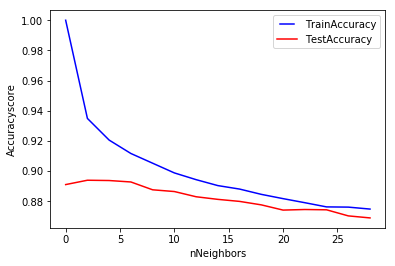

In [106]:
plot(acc_train_results, acc_test_results, 'Accuracy', 'Neighbors')

#### Precisão

In [107]:
prec_train_results = [prec_train['prec_train'] for prec_train in scores]
prec_test_results = [prec_train['prec_test'] for prec_train in scores]

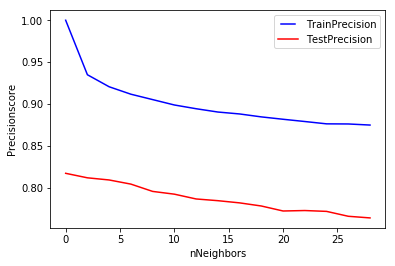

In [108]:
plot(prec_train_results, prec_test_results, 'Precision', 'Neighbors')

#### Recall

In [109]:
rec_train_results = [rec_train['recall_train'] for rec_train in scores]
rec_test_results = [rec_train['recall_test'] for rec_train in scores]

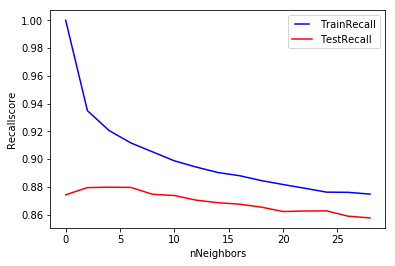

In [110]:
plot(rec_train_results, rec_test_results, 'Recall', 'Neighbors')

## Random Forest

## Gradient Tree Boosting